# Survival Analysis

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py
import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter introduces "survival analysis", which is a set of statistical methods used to answer questions about the time until an event.
In the context of medicine it is literally about survival, but it can be applied to the time until any kind of event, or instead of time it can be about space or other dimensions.

Survival analysis is challenging because the data we have are often incomplete.  But as we'll see, Bayesian methods are particularly good at working with incomplete data.

As examples, we'll consider two applications that are a little less serious than life and death: the time until light bulbs fail and the time until dogs in a shelter are adopted.
To describe these "survival times", we'll use the Weibull distribution.

## The Weibull Distribution

The [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) is often used in survival analysis because it is a good model for the distribution of lifetimes for manufactured products, at least over some parts of the range.

SciPy provides several versions of the Weibull distribution; the one we'll use is called `weibull_min`.
To make the interface consistent with our notation, I'll wrap it in a function that takes as parameters $\lambda$, which mostly affects the location or "central tendency" of the distribution, and $k$, which affects the shape.

In [4]:
from scipy.stats import weibull_min

def weibull_dist(lam, k):
    return weibull_min(k, scale=lam)

As an example, here's a Weibull distribution with parameters $\lambda=3$ and $k=0.8$.

In [5]:
lam = 3
k = 0.8
actual_dist = weibull_dist(lam, k)

The result is an object that represents the distribution.
Here's what the Weibull CDF looks like with those parameters.

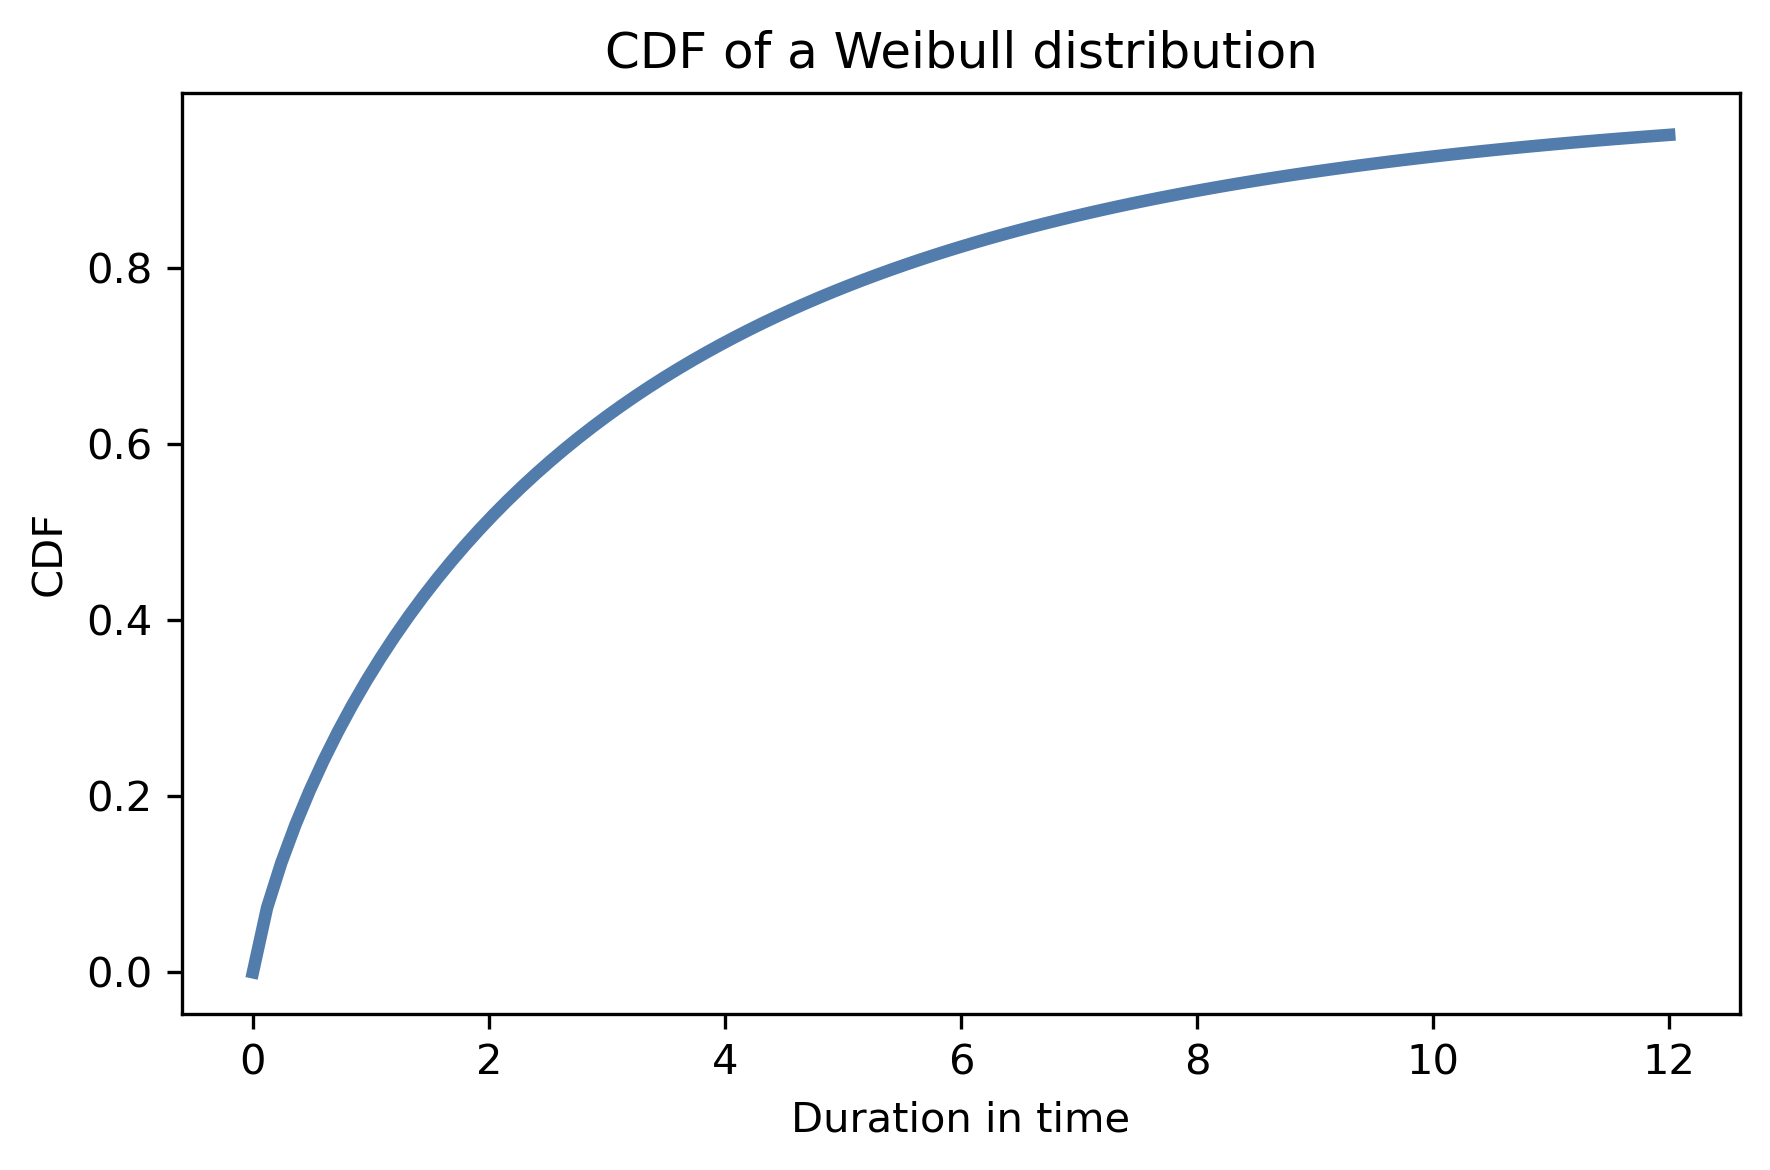

In [6]:
import numpy as np
from empiricaldist import Cdf
from utils import decorate

qs = np.linspace(0, 12, 101)
ps = actual_dist.cdf(qs)
cdf = Cdf(ps, qs)
cdf.plot()

decorate(xlabel='Duration in time', 
         ylabel='CDF',
         title='CDF of a Weibull distribution')

`actual_dist` provides `rvs`, which we can use to generate a random sample from this distribution.

In [7]:
np.random.seed(17)

In [8]:
data = actual_dist.rvs(10)
data

array([0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866,
       3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395])

So, given the parameters of the distribution, we can generate a sample.
Now let's see if we can go the other way: given the sample, we'll estimate the parameters.

Here's a uniform prior distribution for $\lambda$:

In [9]:
from utils import make_uniform

lams = np.linspace(0.1, 10.1, num=101)
prior_lam = make_uniform(lams, name='lambda')

And a uniform prior for $k$:

In [10]:
ks = np.linspace(0.1, 5.1, num=101)
prior_k = make_uniform(ks, name='k')

I'll use `make_joint` to make a joint prior distribution for the two parameters.

In [11]:
from utils import make_joint

prior = make_joint(prior_lam, prior_k)

The result is a `DataFrame` that represents the joint prior, with possible values of $\lambda$ across the columns and values of $k$ down the rows.

Now I'll use `meshgrid` to make a 3-D mesh with $\lambda$ on the first axis (`axis=0`), $k$ on the second axis (`axis=1`), and the data on the third axis (`axis=2`).

In [12]:
lam_mesh, k_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, data)

Now we can use `weibull_dist` to compute the PDF of the Weibull distribution for each pair of parameters and each data point.

In [13]:
densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
densities.shape

(101, 101, 10)

The likelihood of the data is the product of the probability densities along `axis=2`.

In [14]:
likelihood = densities.prod(axis=2)
likelihood.sum()

2.0938302958838208e-05

Now we can compute the posterior distribution in the usual way.

In [15]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)

2.052573567183434e-09

The following function encapsulates these steps.
It takes a joint prior distribution and the data, and returns a joint posterior distribution.

In [16]:
def update_weibull(prior, data):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

Here's how we use it.

In [17]:
posterior = update_weibull(prior, data)

And here's a contour plot of the joint posterior distribution.

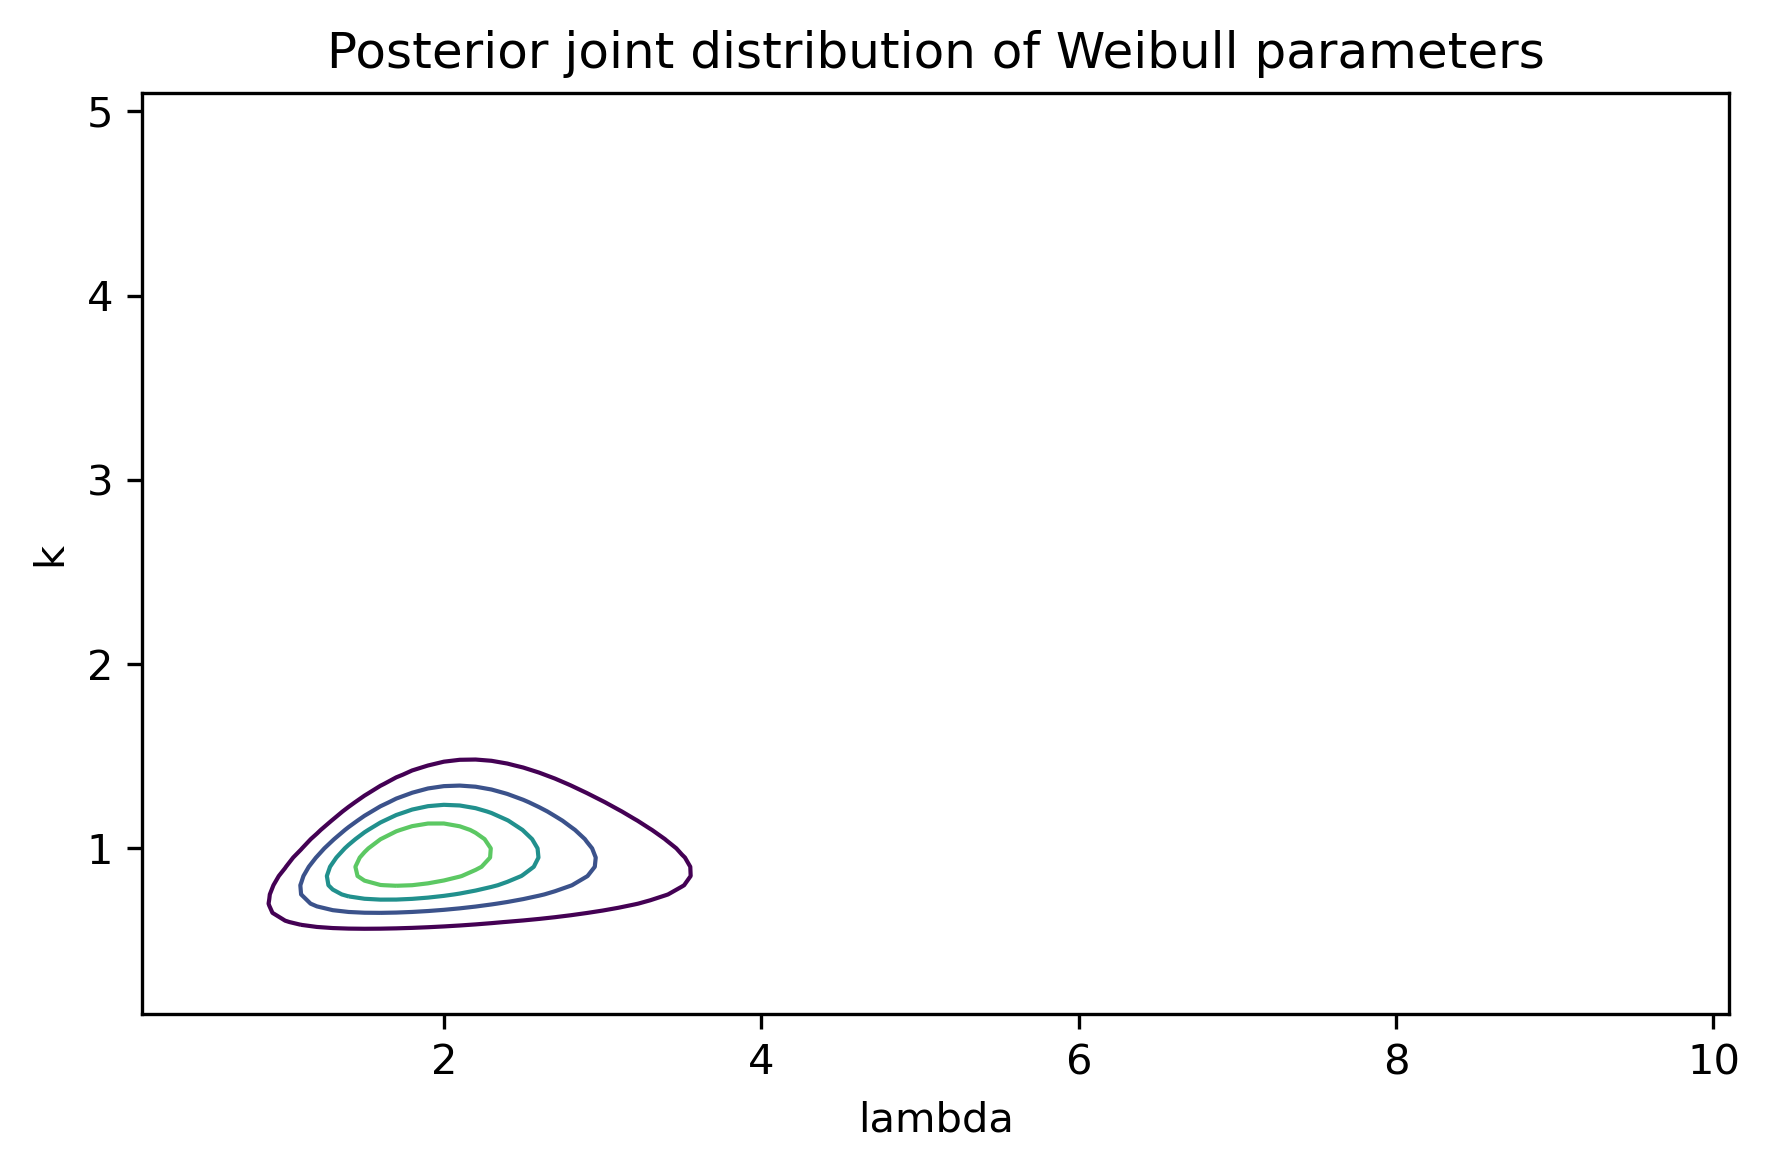

In [18]:
from utils import plot_contour

plot_contour(posterior)
decorate(title='Posterior joint distribution of Weibull parameters')

It looks like the range of likely values for $\lambda$ is about 1 to 4, which contains the actual value we used to generate the data, 3.
And the range for $k$ is about 0.5 to 1.5, which contains the actual value, 0.8.

## Marginal Distributions

To be more precise about these ranges, we can extract the marginal distributions:

In [19]:
from utils import marginal

posterior_lam = marginal(posterior, 0)
posterior_k = marginal(posterior, 1)

And compute the posterior means and 90% credible intervals.

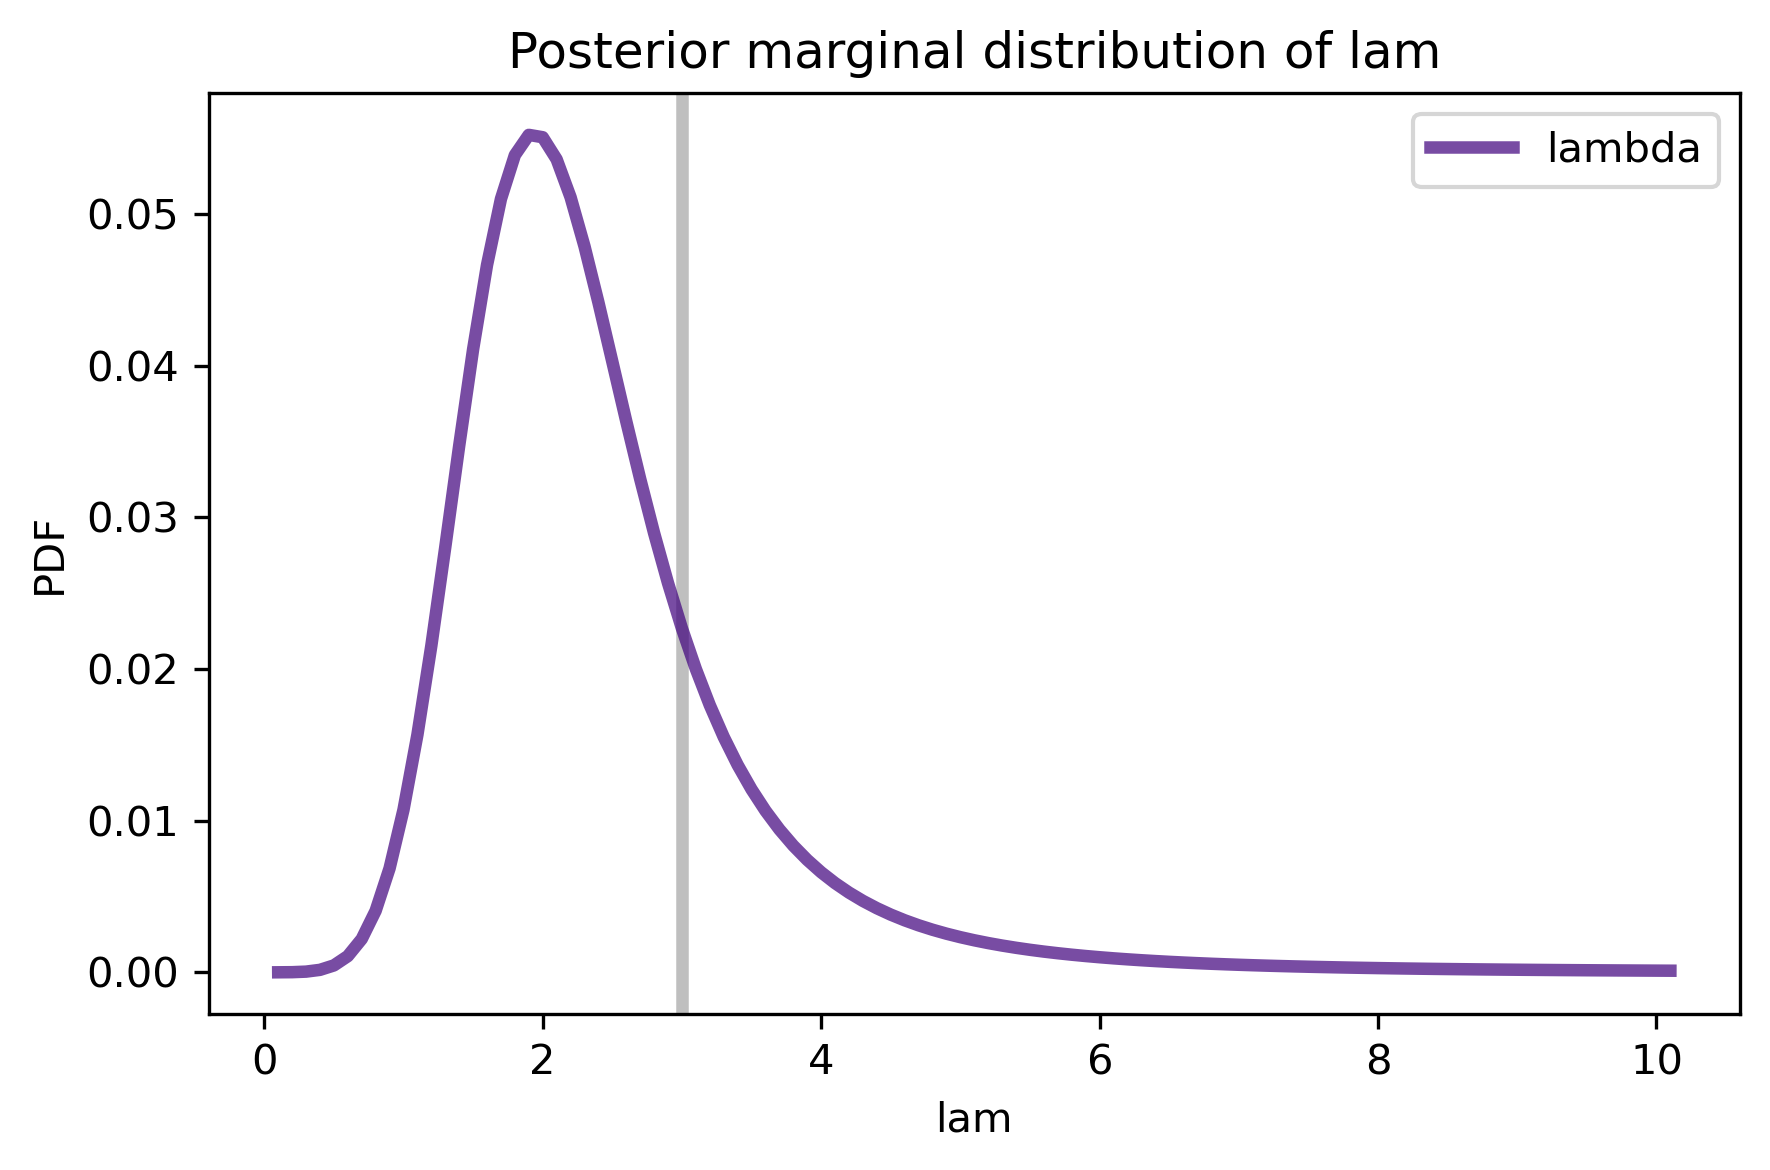

In [20]:
import matplotlib.pyplot as plt

plt.axvline(3, color='C5')
posterior_lam.plot(color='C4', label='lambda')
decorate(xlabel='lam',
         ylabel='PDF', 
         title='Posterior marginal distribution of lam')

The vertical gray line show the actual value of $\lambda$.

Here's the marginal posterior distribution for $k$.

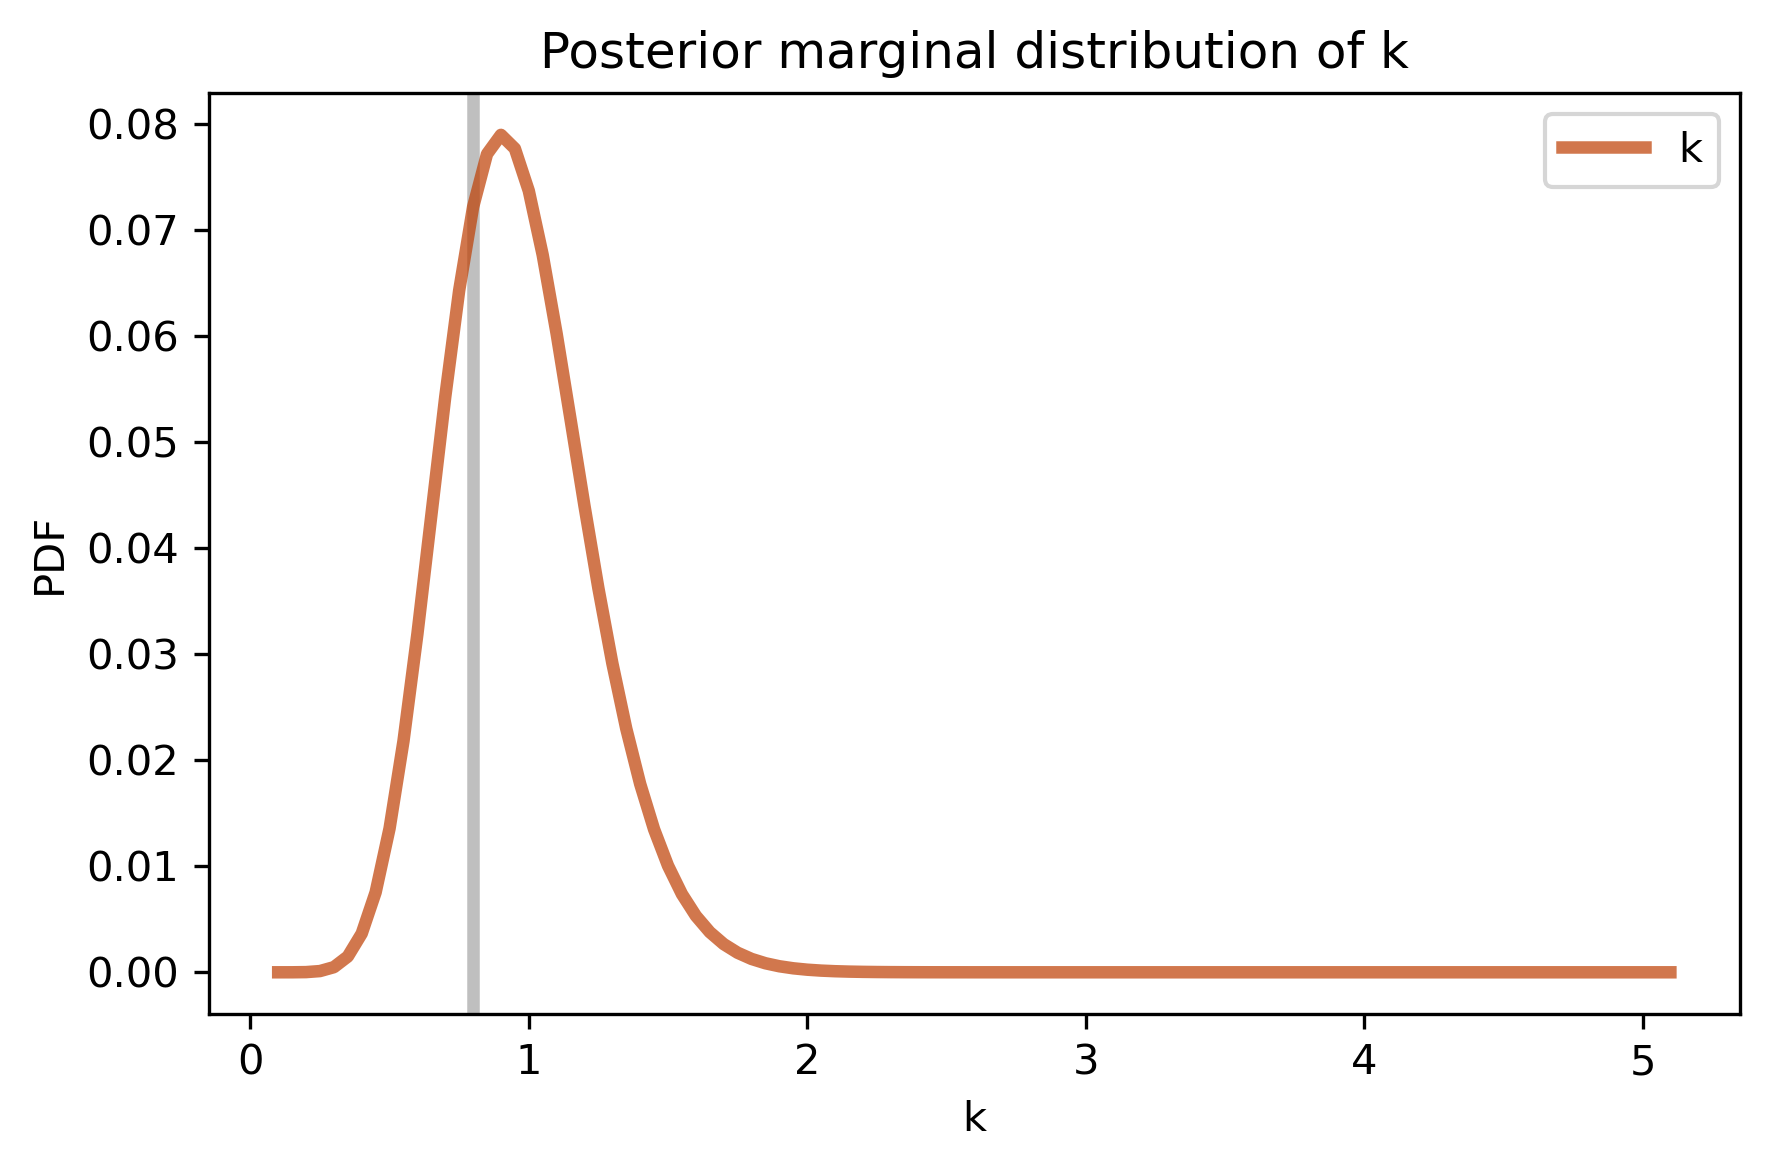

In [21]:
plt.axvline(0.8, color='C5')
posterior_k.plot(color='C12', label='k')
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

The posterior distributions are wide, which means that with only 10 data points we can't estimated the parameters precisely.
But for both parameters, the actual value falls in the credible interval.

In [22]:
print(lam, posterior_lam.credible_interval(0.9))

3 [1.2 4.4]


In [23]:
print(k, posterior_k.credible_interval(0.9))

0.8 [0.6 1.4]


## Incomplete Data

In the previous example we were given 10 random values from a Weibull distribution, and we used them to estimate the parameters (which we pretended we didn't know).

But in many real-world scenarios, we don't have complete data; in particular, when we observe a system at a point in time, we generally have information about the past, but not the future.

As an example, suppose you work at a dog shelter and you are interested in the time between the arrival of a new dog and when it is adopted.
Some dogs might be snapped up immediately; others might have to wait longer.
The people who operate the shelter might want to make inferences about the distribution of these residence times.

Suppose you monitor arrivals and departures over a 8 weeks, and 10 dogs arrive during that interval.
I'll assume that their arrival times are distributed uniformly, so I'll generate random values like this.

In [24]:
np.random.seed(19)

In [25]:
start = np.random.uniform(0, 8, size=10)
start

array([0.78026881, 6.08999773, 1.97550379, 1.1050535 , 2.65157251,
       0.66399652, 5.37581665, 6.45275039, 7.86193532, 5.08528588])

Now let's suppose that the residence times follow the Weibull distribution we used in the previous example.
We can generate a sample from that distribution like this:

In [26]:
np.random.seed(17)

In [27]:
duration = actual_dist.rvs(10)
duration

array([0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866,
       3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395])

I'll use these values to construct a `DataFrame` that contains the arrival and departure times for each dog, called `start` and `end`.

In [28]:
import pandas as pd

d = dict(start=start, end=start+duration)
obs = pd.DataFrame(d)

For display purposes, I'll sort the rows of the `DataFrame` by arrival time.

In [29]:
obs = obs.sort_values(by='start', ignore_index=True)
obs

,start,end
0,0.663997,3.921447
1,0.780269,1.585242
2,1.105053,1.213680
3,1.975504,2.408592
4,2.651573,7.824921
5,5.085286,6.169150
6,5.375817,8.431375
7,6.089998,8.205769
8,6.452750,8.926761
9,7.861935,7.915343


Notice that several of the lifelines extend past the observation window of 8 weeks.
So if we observed this system at the beginning of Week 8, we would have incomplete information.
Specifically, we would not know the future adoption times for Dogs 6, 7, and 8.

I'll simulate this incomplete data by identifying the lifelines that extend past the observation window:

In [30]:
censored = obs['end'] > 8

`censored` is a  Boolean Series that is `True` for lifelines that extend past Week 8.

Data that is not available is sometimes called "censored" in the sense that it is hidden from us.
But in this case it is hidden because we don't know the future, not because someone is censoring it.

For the lifelines that are censored, I'll modify `end` to indicate when they are last observed and `status` to indicate that the observation is incomplete. 

In [31]:
obs.loc[censored, 'end'] = 8
obs.loc[censored, 'status'] = 0

Now we can plot a "lifeline" for each dog, showing the arrival and departure times on a time line.

In [32]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    decorate(xlabel='Time (weeks)',
             ylabel='Dog index',
             title='Lifelines showing censored and uncensored observations')

    plt.gca().invert_yaxis()

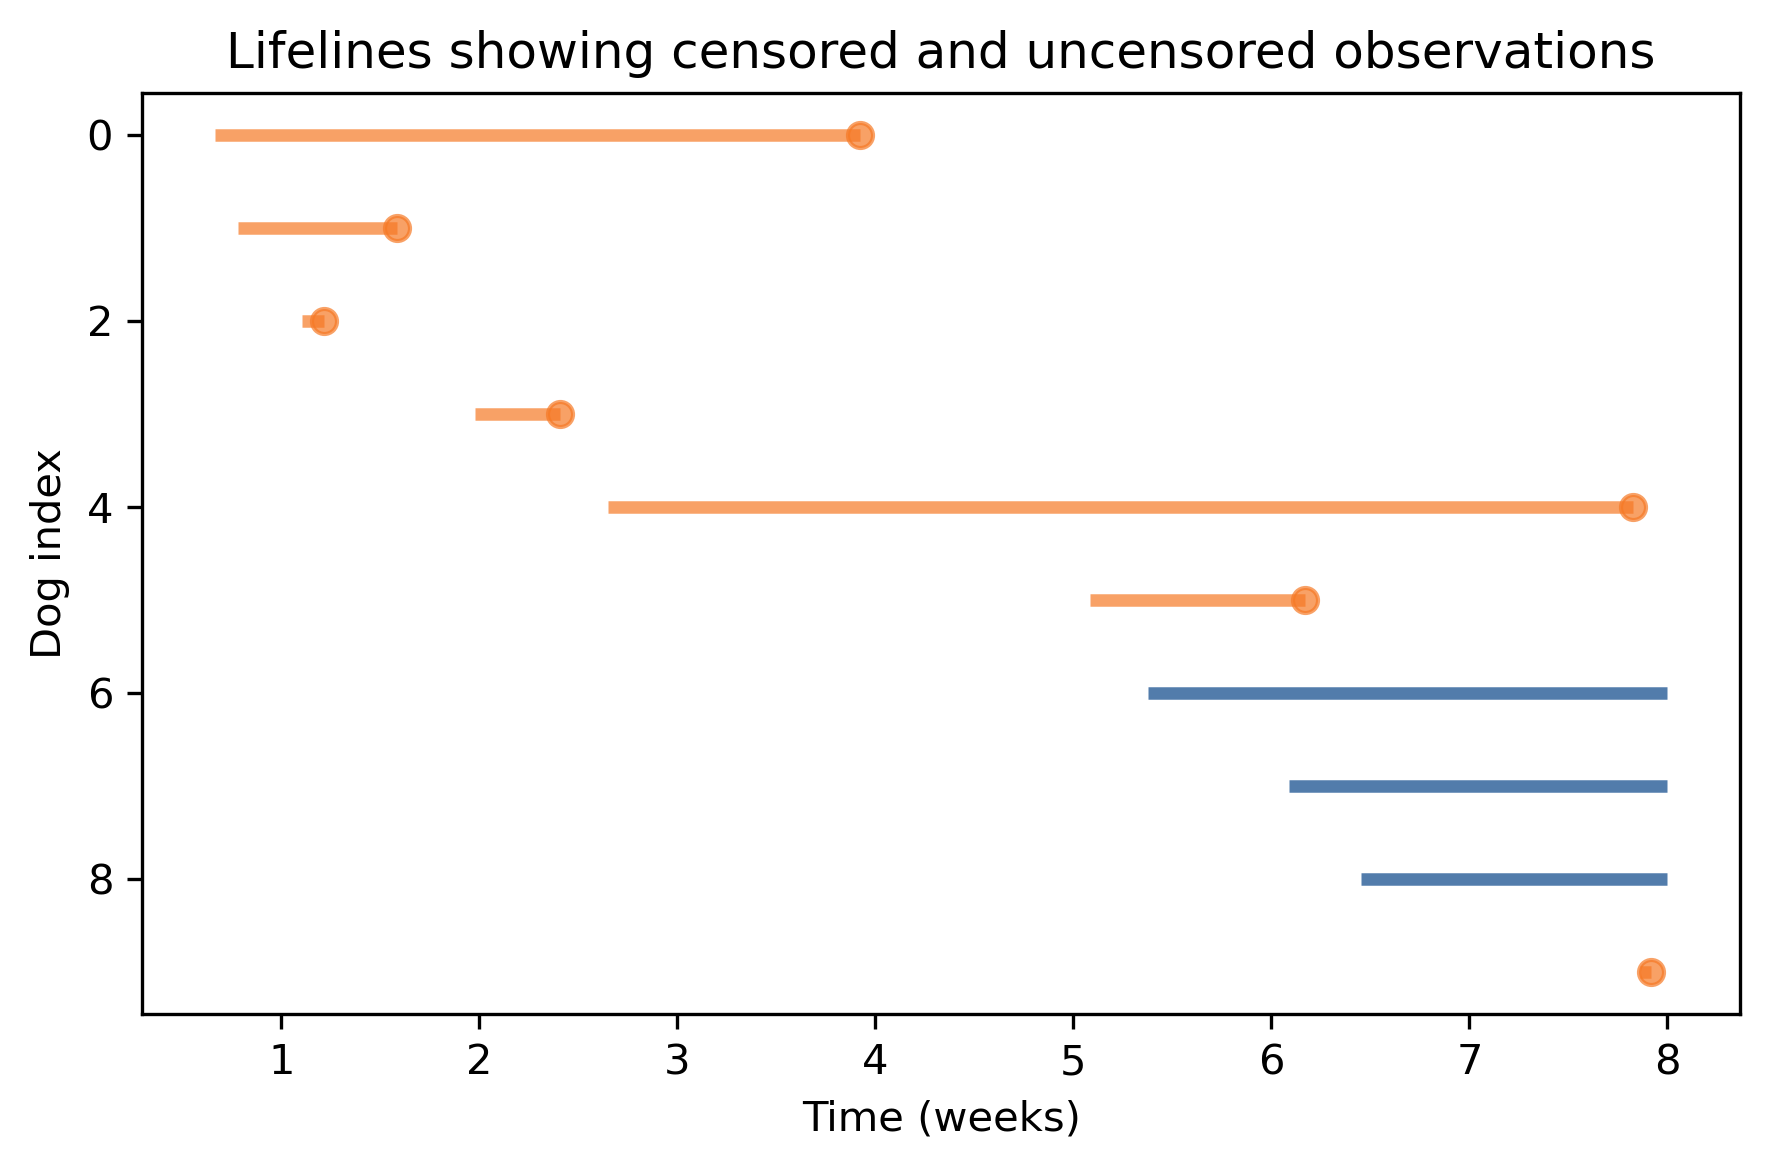

In [33]:
plot_lifelines(obs)

And I'll add one more column to the table, which contains the duration of the observed parts of the lifelines.

In [34]:
obs['T'] = obs['end'] - obs['start']

What we have simulated is the data that would be available at the beginning of Week 8.

## Using Incomplete Data

Now, let's see how we can use both kinds of data, complete and incomplete, to infer the parameters of the distribution of residence times.

First I'll split the data into two sets: `data1` contains residence times for dogs whose arrival and departure times are known; `data2` contains incomplete residence times for dogs who were not adopted during the observation interval.

In [35]:
data1 = obs.loc[~censored, 'T']
data2 = obs.loc[censored, 'T']

In [36]:
data1

0    3.257451
1    0.804973
2    0.108626
3    0.433088
4    5.173349
5    1.083864
9    0.053408
Name: T, dtype: float64

In [37]:
data2

6    2.624183
7    1.910002
8    1.547250
Name: T, dtype: float64

For the complete data, we can use `update_weibull`, which uses the PDF of the Weibull distribution to compute the likelihood of the data.

In [38]:
posterior1 = update_weibull(prior, data1)

For the incomplete data, we have to think a little harder.
At the end of the observation interval, we don't know what the residence time will be, but we can put a lower bound on it; that is, we can say that the residence time will be greater than `T`.

And that means that we can compute the likelihood of the data using the survival function, which is the probability that a value from the distribution exceeds `T`.

The following function is identical to `update_weibull` except that it uses `sf`, which computes the survival function, rather than `pdf`.

In [39]:
def update_weibull_incomplete(prior, data):
    """Update the prior using incomplete data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    # evaluate the survival function
    probs = weibull_dist(lam_mesh, k_mesh).sf(data_mesh)
    likelihood = probs.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

Here's the update with the incomplete data.

In [40]:
posterior2 = update_weibull_incomplete(posterior1, data2)

And here's what the joint posterior distribution looks like after both updates.

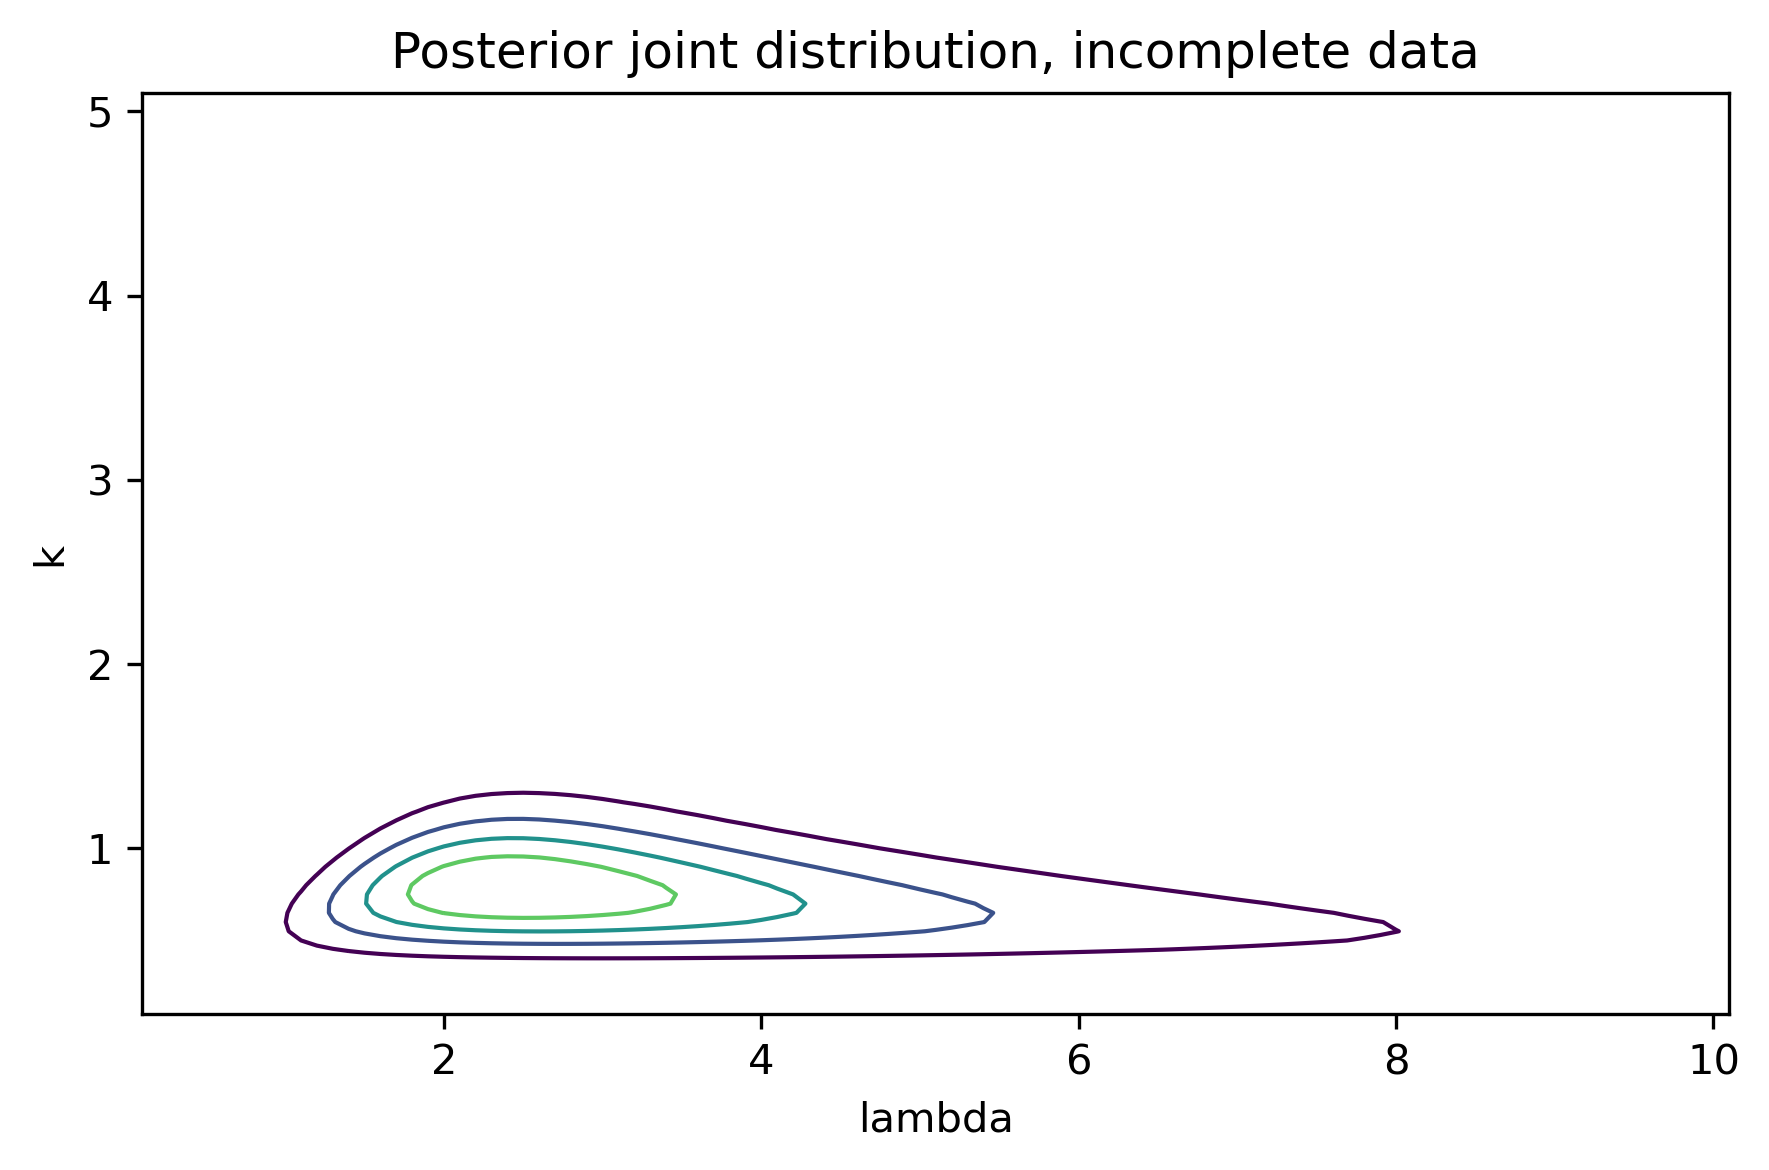

In [41]:
plot_contour(posterior2)
decorate(title='Posterior joint distribution, incomplete data')

Compared to the previous contour plot, it looks like the range of likely values for $\lambda$ is substantially wider.
We can see that more clearly by looking at the marginal distributions.

In [42]:
posterior_lam2 = marginal(posterior2, 0)
posterior_k2 = marginal(posterior2, 1)

Here's the posterior marginal distribution for $\lambda$ compared to the distribution we got using all complete data.

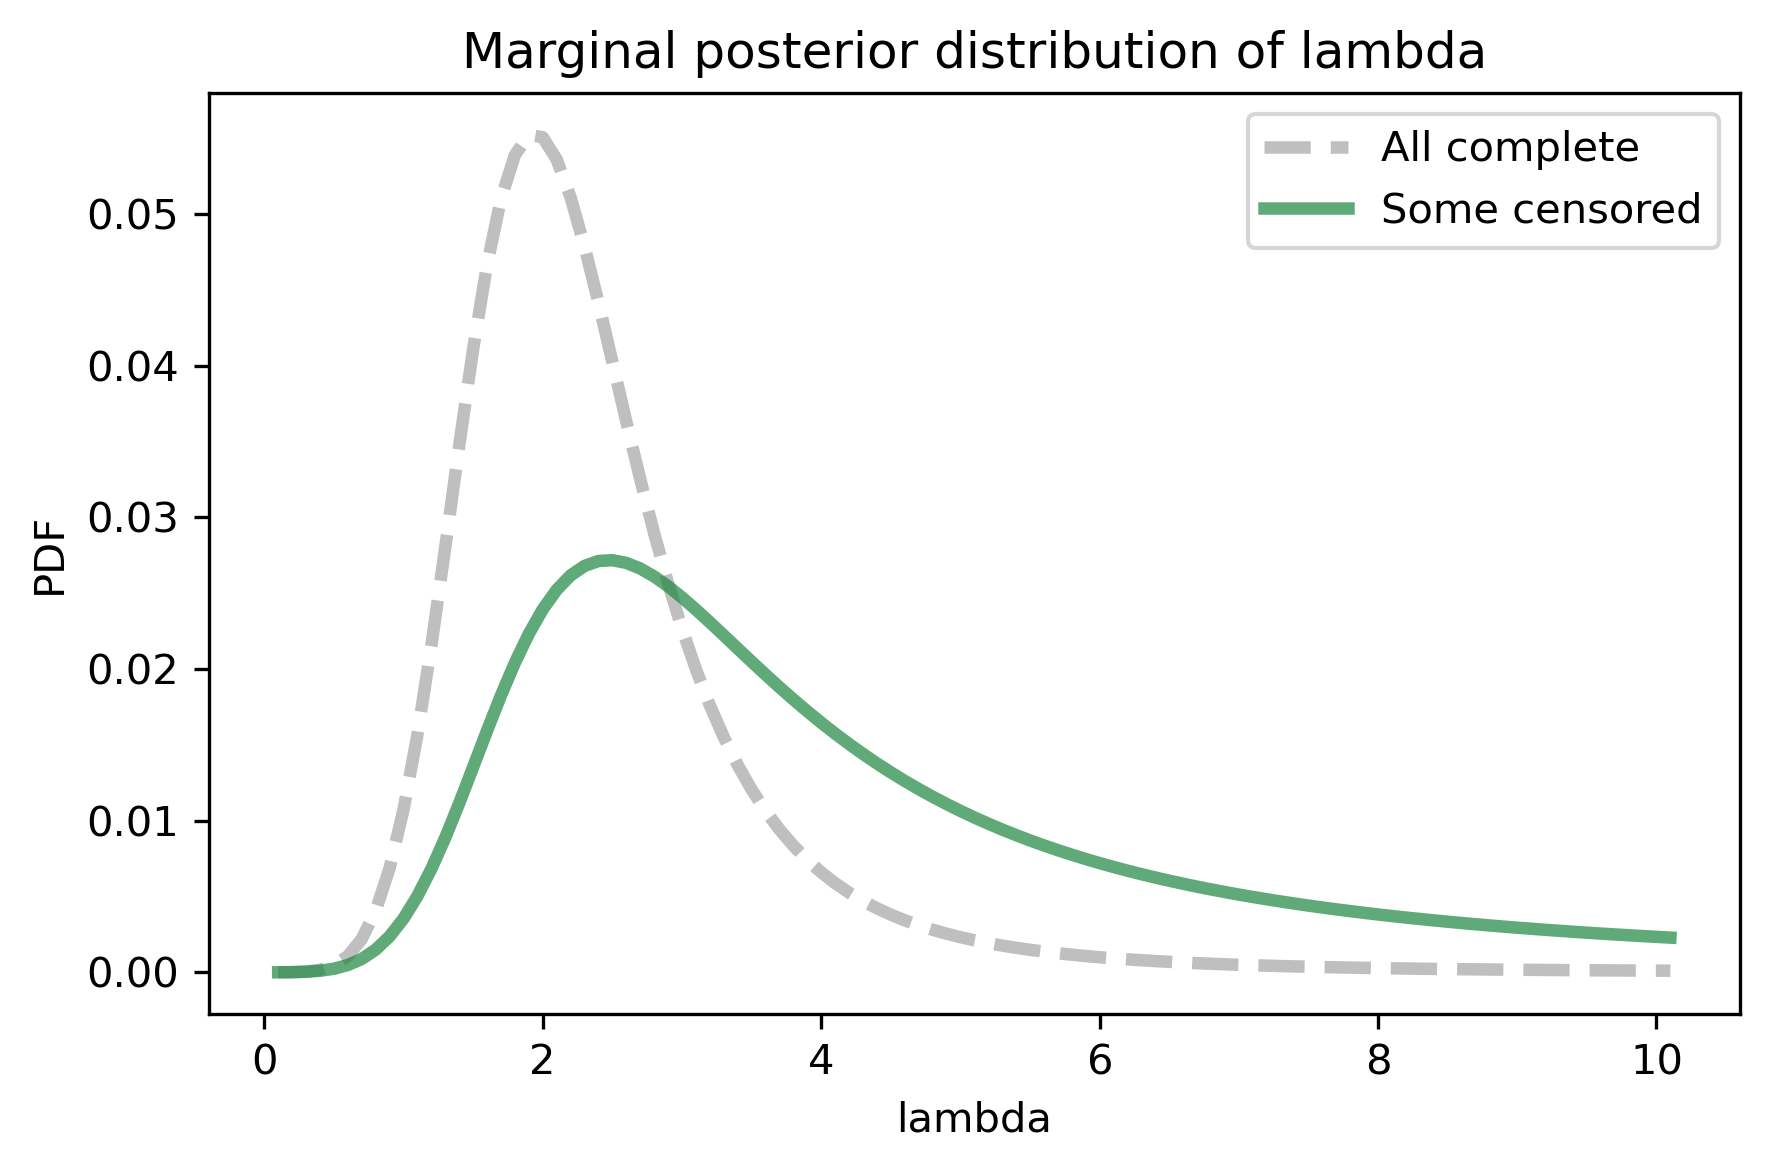

In [43]:
posterior_lam.plot(color='C5', label='All complete',
                   linestyle='dashed')
posterior_lam2.plot(color='C2', label='Some censored')

decorate(xlabel='lambda',
         ylabel='PDF', 
         title='Marginal posterior distribution of lambda')

The distribution with some incomplete data is substantially wider.

As an aside, notice that the posterior distribution does not come all the way to 0 on the right side.
That suggests that the range of the prior distribution is not wide enough to cover the most likely values for this parameter.
If I were concerned about making this distribution more accurate, I would go back and run the update again with a wider prior.

Here's the posterior marginal distribution for $k$:

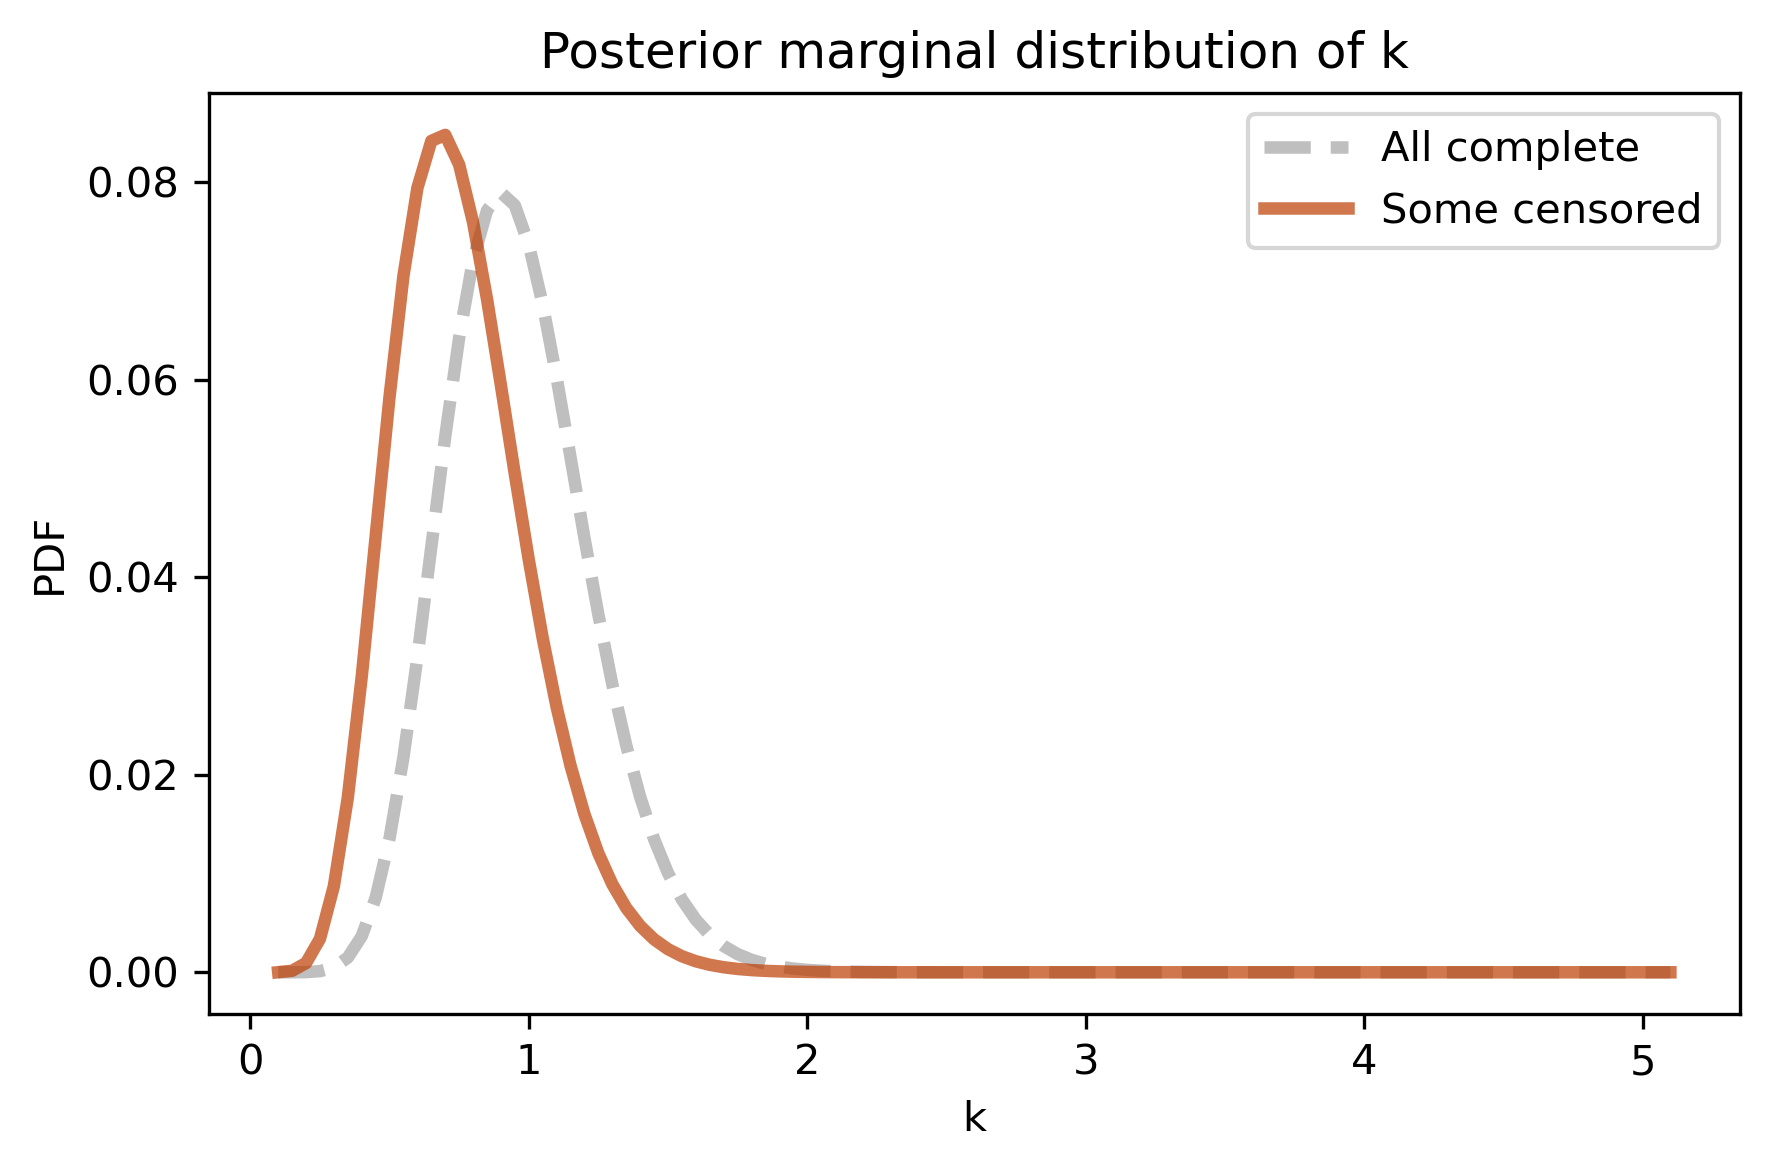

In [44]:
posterior_k.plot(color='C5', label='All complete',
                   linestyle='dashed')
posterior_k2.plot(color='C12', label='Some censored')

decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

In this example, the marginal distribution is shifted to the left when we have incomplete data, but it is not substantially wider.

In summary, we have seen how to combine complete and incomplete data to estimate the parameters of a Weibull distribution, which is useful in many real-world scenarios where some of the data are censored.

In general, the posterior distributions are wider when we have incomplete data, because less information leads to more uncertainty.

This example is based on data I generated; in the next section we'll do a similar analysis with real data.

## Light Bulbs

In 2007 [researchers ran an experiment](https://www.researchgate.net/publication/225450325_Renewal_Rate_of_Filament_Lamps_Theory_and_Experiment) to characterize the distribution of lifetimes for light bulbs.
Here is their description of the experiment:

> An assembly of 50 new Philips (India) lamps with the rating 40 W, 220 V (AC) was taken and installed in the horizontal orientation and uniformly distributed over a lab area 11 m x 7 m.
>
> The assembly was monitored at regular intervals of 12 h to look for failures. The instants of recorded failures were [recorded] and a total of 32 data points were obtained such that even the last bulb failed. 

In [45]:
import os

datafile = 'lamps.csv'
if not os.path.exists(datafile):
    !wget https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv

We can load the data into a `DataFrame` like this:

In [46]:
df = pd.read_csv('lamps.csv', index_col=0)
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


Column `h` contains the times when bulbs failed in hours; Column `f` contains the number of bulbs that failed at each time.
We can represent these values and frequencies using a `Pmf`, like this:

In [47]:
from empiricaldist import Pmf

pmf_bulb = Pmf(df['f'].to_numpy(), df['h'])
pmf_bulb.normalize()

50

Because of the design of this experiment, we can consider the data to be a representative sample from the distribution of lifetimes, at least for light bulbs that are lit continuously.

The average lifetime is about 1400 h.

In [48]:
pmf_bulb.mean()

1413.84

Assuming that these data are well modeled by a Weibull distribution, let's estimate the parameters that fit the data.
Again, I'll start with uniform priors for $\lambda$ and $k$:

In [49]:
lams = np.linspace(1000, 2000, num=51)
prior_lam = make_uniform(lams, name='lambda')

In [50]:
ks = np.linspace(1, 10, num=51)
prior_k = make_uniform(ks, name='k')

For this example, there are 51 values in the prior distribution, rather than the usual 101.  That's because we are going to use the posterior distributions to do some computationally-intensive calculations.
They will run faster with fewer values, but the results will be less precise.

As usual, we can use `make_joint` to make the prior joint distribution.

In [51]:
prior_bulb = make_joint(prior_lam, prior_k)

Although we have data for 50 light bulbs, there are only 32 unique lifetimes in the dataset.  For the update, it is convenient to express the data in the form of 50 lifetimes, with each lifetime repeated the given number of times.
We can use `np.repeat` to transform the data.

In [52]:
data_bulb = np.repeat(df['h'], df['f'])
len(data_bulb)

50

Now we can use `update_weibull` to do the update.

In [53]:
posterior_bulb = update_weibull(prior_bulb, data_bulb)

Here's what the posterior joint distribution looks like:

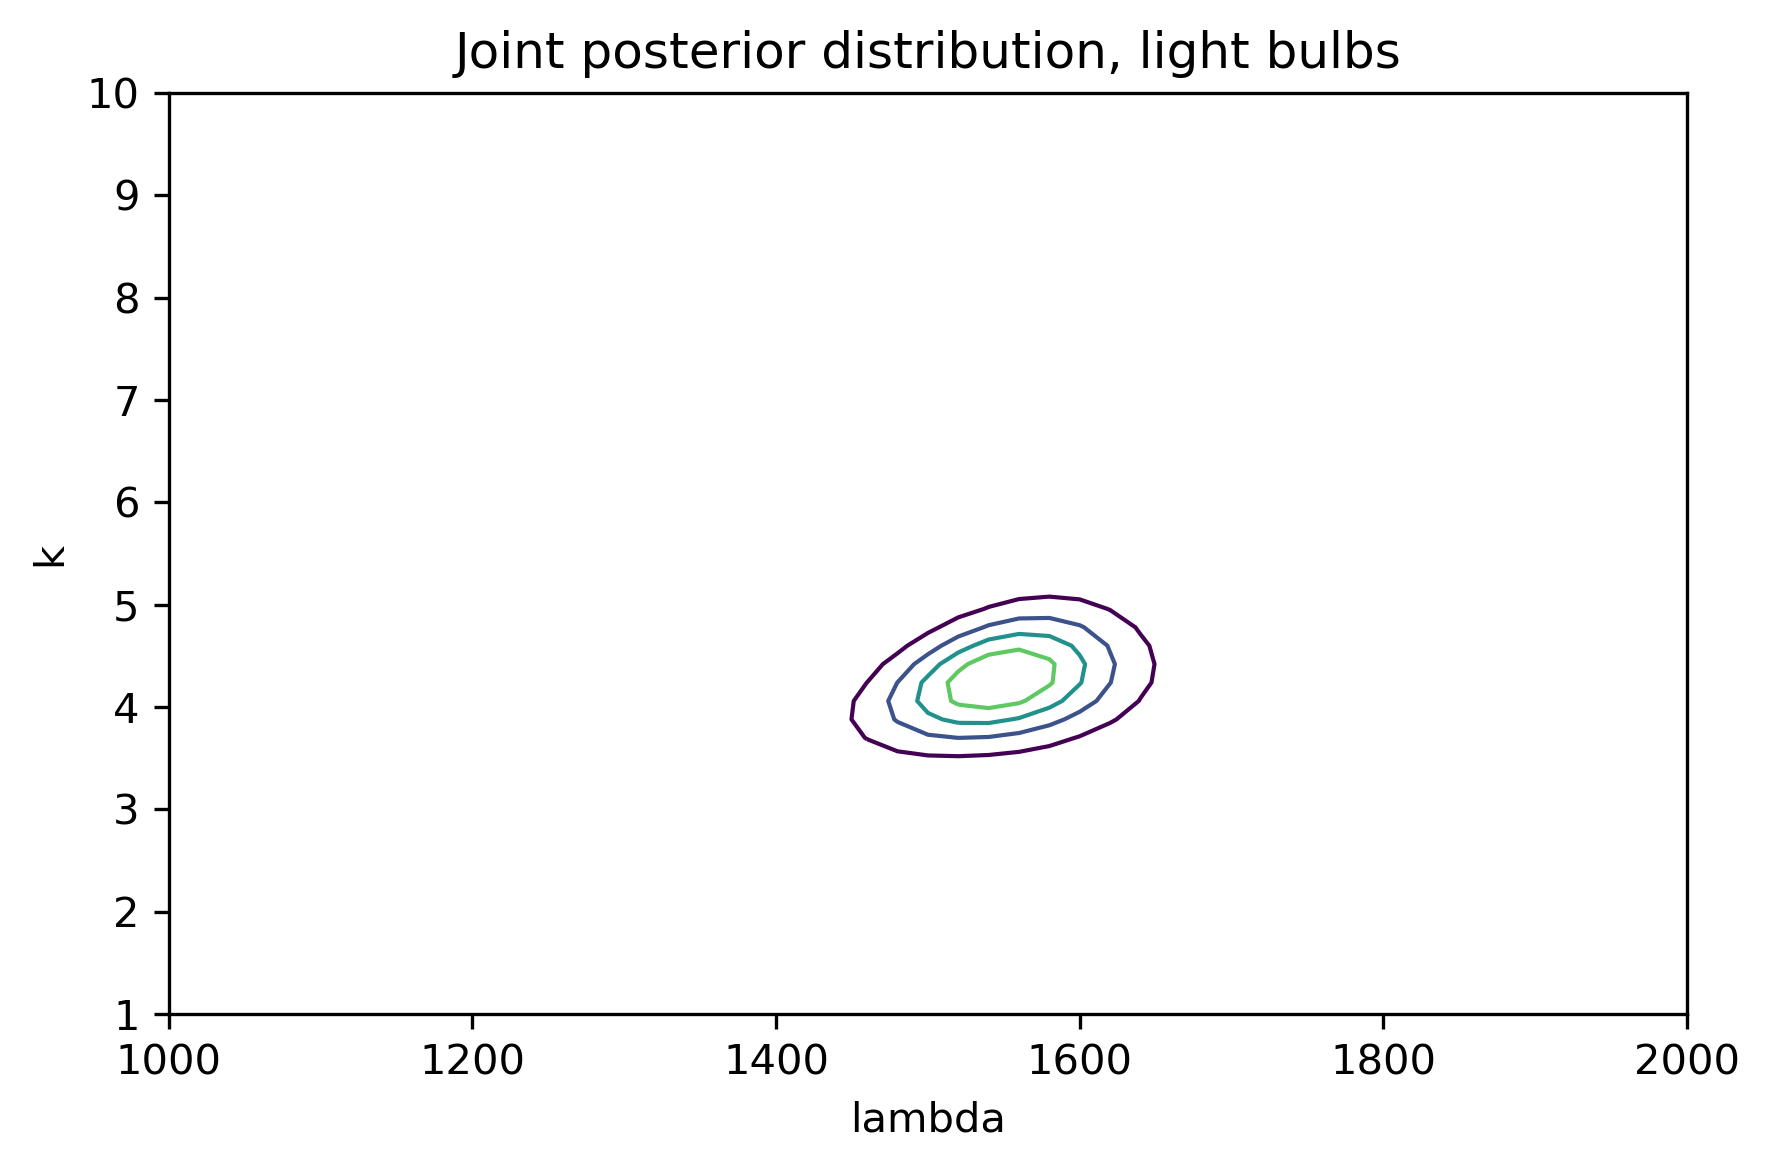

In [54]:
plot_contour(posterior_bulb)
decorate(title='Joint posterior distribution, light bulbs')

To summarize this joint posterior distribution, we'll compute the posterior mean lifetime.

## Posterior Means

To compute the posterior mean of a joint distribution, we'll make a mesh that contains the values of $\lambda$ and $k$.

In [55]:
lam_mesh, k_mesh = np.meshgrid(
    prior_bulb.columns, prior_bulb.index)

Now for each pair of parameters we'll use `weibull_dist` to compute the mean.

In [56]:
means = weibull_dist(lam_mesh, k_mesh).mean()
means.shape

(51, 51)

The result is an array with the same dimensions as the joint distribution.

Now we need to weight each mean with the corresponding probability from the joint posterior.

In [57]:
prod = means * posterior_bulb

Finally we compute the sum of the weighted means.

In [58]:
prod.to_numpy().sum()

1412.7242774305005

Based on the posterior distribution, we think the mean lifetime is about 1413 hours.

The following function encapsulates these steps:

In [59]:
def joint_weibull_mean(joint):
    """Compute the mean of a joint distribution of Weibulls."""
    lam_mesh, k_mesh = np.meshgrid(
        joint.columns, joint.index)
    means = weibull_dist(lam_mesh, k_mesh).mean()
    prod = means * joint
    return prod.to_numpy().sum()

## Incomplete Information

The previous update was not quite right, because it assumed each light bulb died at the instant we observed it.  
According to the report, the researchers only checked the bulbs every 12 hours.  So if they see that a bulb has died, they know only that it died during the 12 hours since the last check.

It is more strictly correct to use the following update function, which uses the CDF of the Weibull distribution to compute the probability that a bulb dies during a given 12 hour interval.

In [60]:
def update_weibull_between(prior, data, dt=12):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    dist = weibull_dist(lam_mesh, k_mesh)
    cdf1 = dist.cdf(data_mesh)
    cdf2 = dist.cdf(data_mesh-12)
    likelihood = (cdf1 - cdf2).prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

The probability that a value falls in an interval is the difference between the CDF at the beginning and end of the interval.

Here's how we run the update.

In [61]:
posterior_bulb2 = update_weibull_between(prior_bulb, data_bulb)

And here are the results.

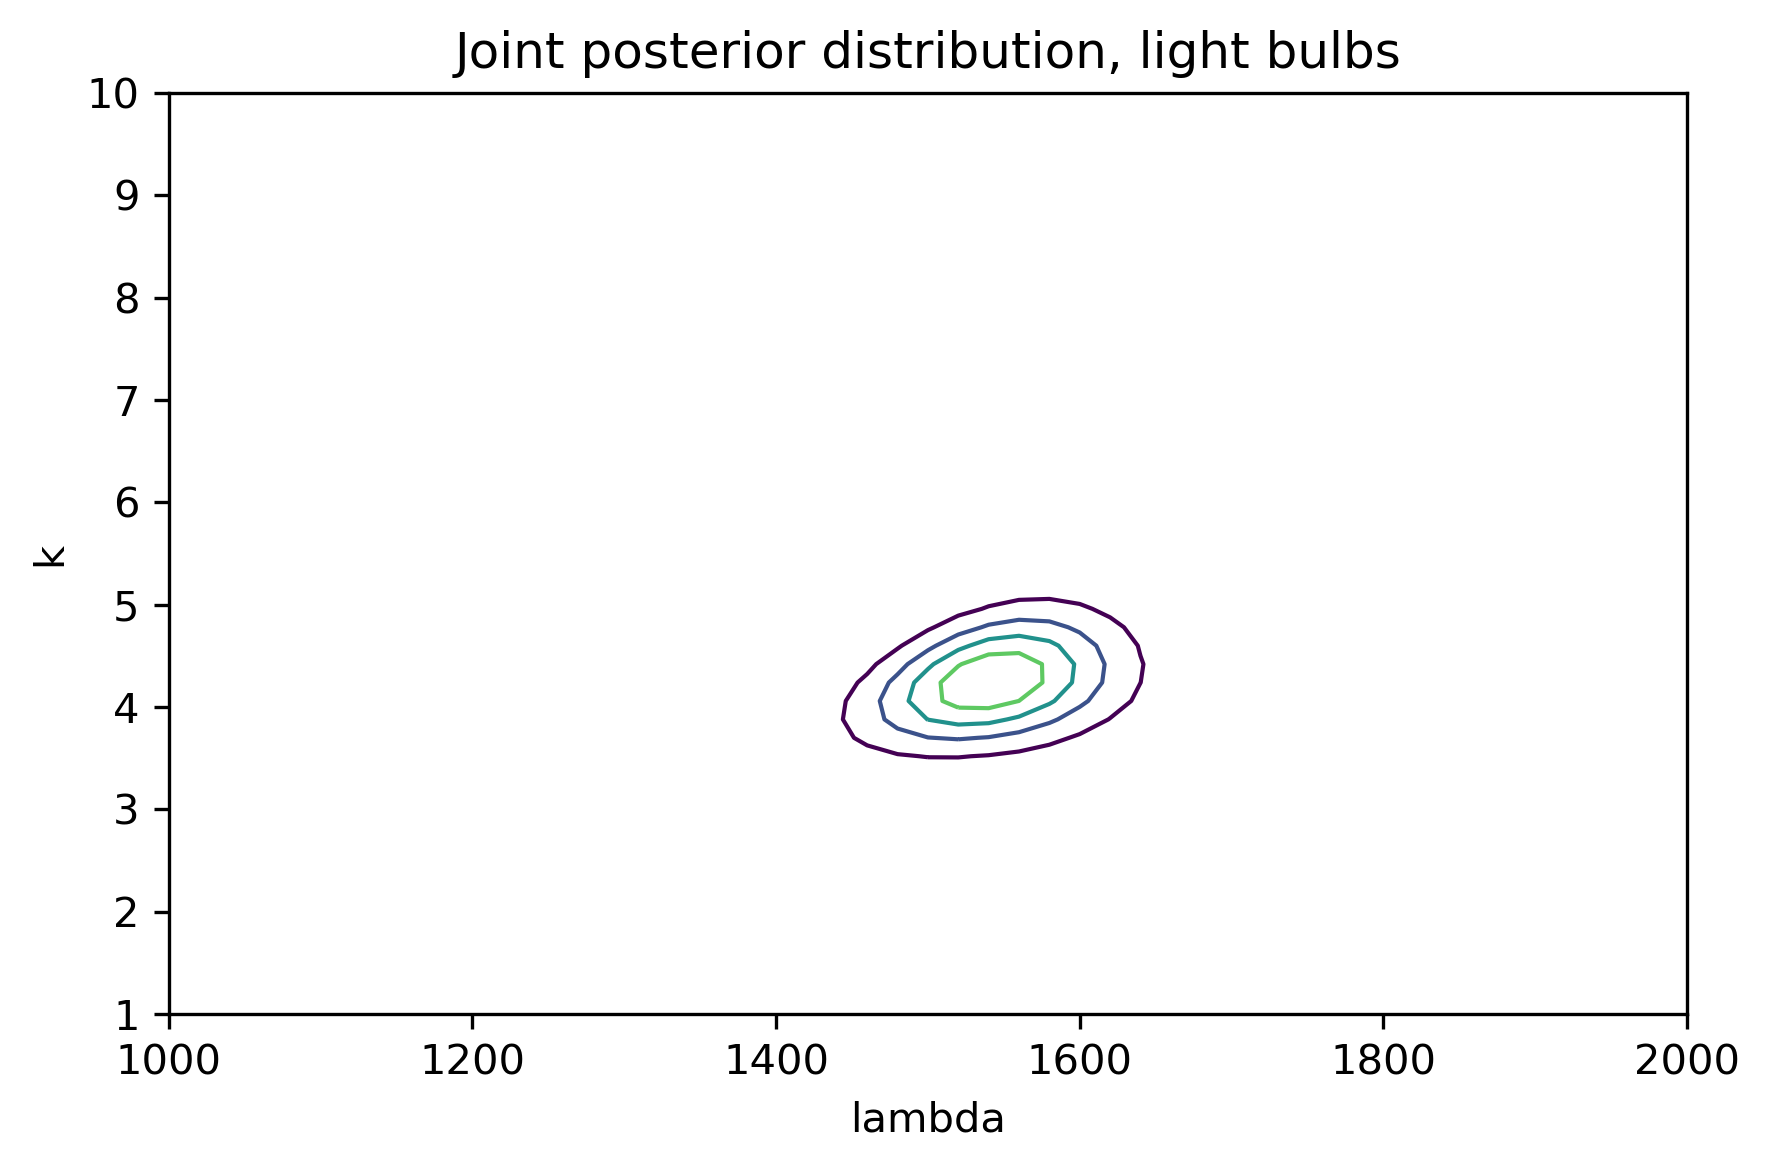

In [62]:
plot_contour(posterior_bulb2)
decorate(title='Joint posterior distribution, light bulbs')

Visually this result is almost identical to what we got using the PDF.
And that's good news, because it suggests that using the PDF can be a good approximation even if it's not strictly correct.

To see whether it makes any difference at all, let's check the posterior means.

In [63]:
joint_weibull_mean(posterior_bulb)

1412.7242774305005

In [64]:
joint_weibull_mean(posterior_bulb2)

1406.8171982320873

When we take into account the 12-hour interval between observations, the posterior mean is about 6 hours less.
And that makes sense: if we assume that a bulb is equally likely to expire at any point in the interval, the average would be the midpoint of the interval.

## Posterior Predictive Distribution

Suppose you install 100 light bulbs of the kind in the previous section, and you come back to check on them after 1000 hours.  Based on the posterior distribution we just computed, what is the distribution of the number of bulbs you find dead?

If we knew the parameters of the Weibull distribution for sure, the answer would be a binomial distribution.

For example, if we know that $\lambda=1550$ and $k=4.25$, we can use `weibull_dist` to compute the probability that a bulb dies before you return:

In [65]:
lam = 1550
k = 4.25
t = 1000

prob_dead = weibull_dist(lam, k).cdf(t)
prob_dead

0.14381685899960547

If there are 100 bulbs and each has this probability of dying, the number of dead bulbs follows a binomial distribution.

In [66]:
from utils import make_binomial

n = 100
p = prob_dead
dist_num_dead = make_binomial(n, p)

And here's what it looks like.

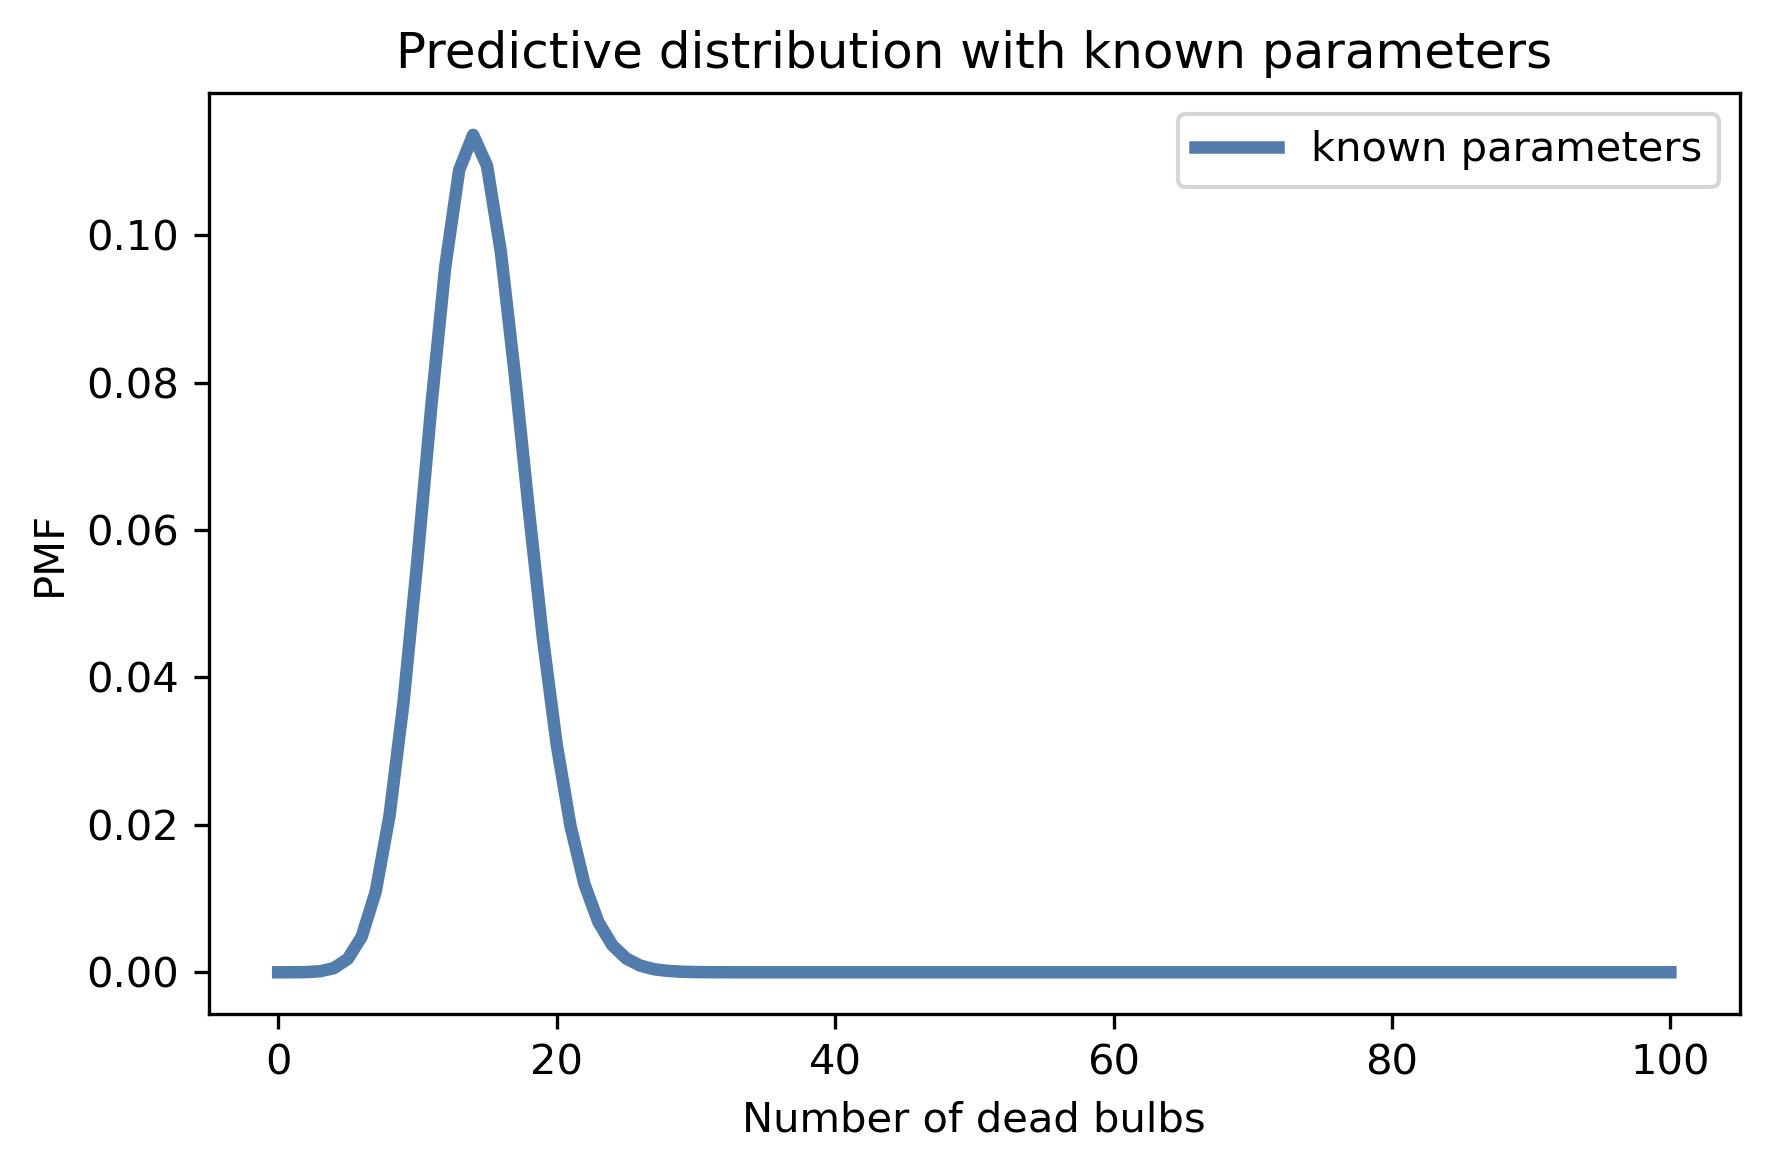

In [67]:
dist_num_dead.plot(label='known parameters')

decorate(xlabel='Number of dead bulbs',
         ylabel='PMF',
         title='Predictive distribution with known parameters')

But that's based on the assumption that we know $\lambda$ and $k$, and we don't.
Instead, we have a posterior distribution that contains possible values of these parameters and their probabilities.

So the posterior predictive distribution is not a single binomial; instead it is a mixture of binomials, weighted with the posterior probabilities.

We can use `make_mixture` to compute the posterior predictive distribution.  
It doesn't work with joint distributions, but we can convert the `DataFrame` that represents a joint distribution to a `Series`, like this:

In [68]:
posterior_series = posterior_bulb.stack()
posterior_series.head()

k    lambda
1.0  1000.0    8.146763e-25
     1020.0    1.210486e-24
     1040.0    1.738327e-24
     1060.0    2.418201e-24
     1080.0    3.265549e-24
dtype: float64

The result is a `Series` with a `MultiIndex` that contains two "levels": the first level contains the values of `k`; the second contains the values of `lam`.

With the posterior in this form, we can iterate through the possible parameters and compute a predictive distribution for each pair.

In [69]:
pmf_seq = []
for (k, lam) in posterior_series.index:
    prob_dead = weibull_dist(lam, k).cdf(t)
    pmf = make_binomial(n, prob_dead)
    pmf_seq.append(pmf)

Now we can use `make_mixture`, passing as parameters the posterior probabilities in `posterior_series` and the sequence of binomial distributions in `pmf_seq`.

In [70]:
from utils import make_mixture

post_pred = make_mixture(posterior_series, pmf_seq)

Here's what the posterior predictive distribution looks like, compared to the binomial distribution we computed with known parameters.

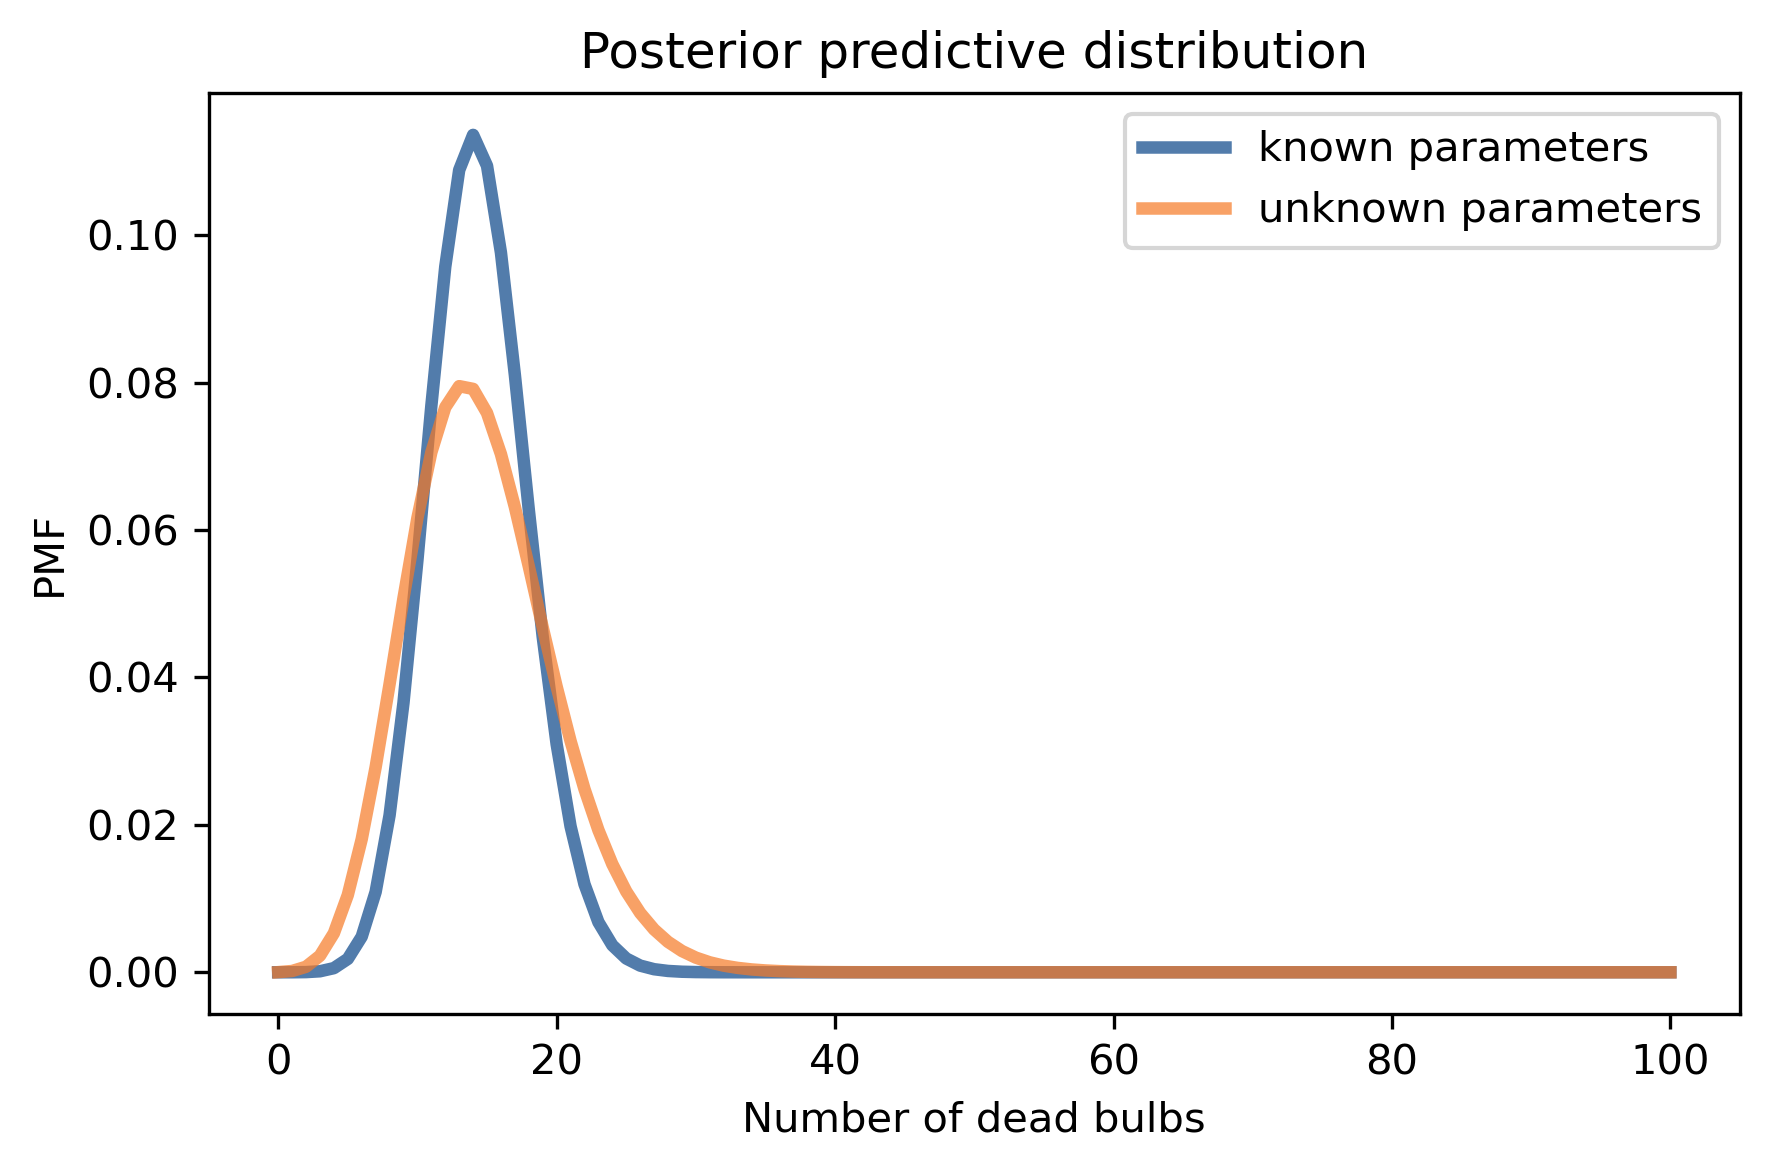

In [71]:
dist_num_dead.plot(label='known parameters')
post_pred.plot(label='unknown parameters')
decorate(xlabel='Number of dead bulbs',
         ylabel='PMF',
         title='Posterior predictive distribution')

The posterior predictive distribution is wider because it represents our uncertainty about the parameters as well as our uncertainty about the number of dead bulbs.

## Summary

This chapter introduces survival analysis, which is used to answer questions about the time until an event, and the Weibull distribution, which is a good model for "lifetimes" (broadly interpreted) in a number of domains.

We used joint distributions to represent prior probabilities for the parameters of the Weibull distribution, and we updated them three ways: knowing the exact duration of a lifetime, knowing a lower bound, and knowing that a lifetime fell in a given interval.

These examples demonstrate a feature of Bayesian methods: they can be adapted to handle incomplete, or "censored", data with only small changes.  As an exercise, you'll have a chance to work with one more type of censored data, when we are given an upper bound on a lifetime.

The methods in this chapter work with any distribution with two parameters.
In the exercises, you'll have a chance to estimate the parameters of a two-parameter gamma distribution, which is used to describe a variety of natural phenomena.

And in the next chapter we'll move on to models with three parameters!

## Exercises

**Exercise:** Using data about the lifetimes of light bulbs, we computed the posterior distribution from the parameters of a Weibull distribution, $\lambda$ and $k$, and the posterior predictive distribution for the number of dead bulbs, out of 100, after 1000 hours.

Now suppose you do the experiment:  You install 100 light bulbs, come back after 1000 hours, and find 20 dead light bulbs.  
Update the posterior distribution based on this data.
How much does it change the posterior mean?

Suggestions:

1. Use a mesh grid to compute the probability of finding a bulb dead after 1000 hours for each pair of parameters.

2. For each of those probabilities, compute the likelihood of finding 20 dead bulbs out of 100.

3. Use those likelihoods to update the posterior distribution.

In [72]:
# Solution

t = 1000

lam_mesh, k_mesh = np.meshgrid(
    prior_bulb.columns, prior_bulb.index)
prob_dead = weibull_dist(lam_mesh, k_mesh).cdf(t)
prob_dead.shape

(51, 51)

In [73]:
# Solution

from scipy.stats import binom

k = 20
n = 100
likelihood = binom(n, prob_dead).pmf(k)
likelihood.shape

(51, 51)

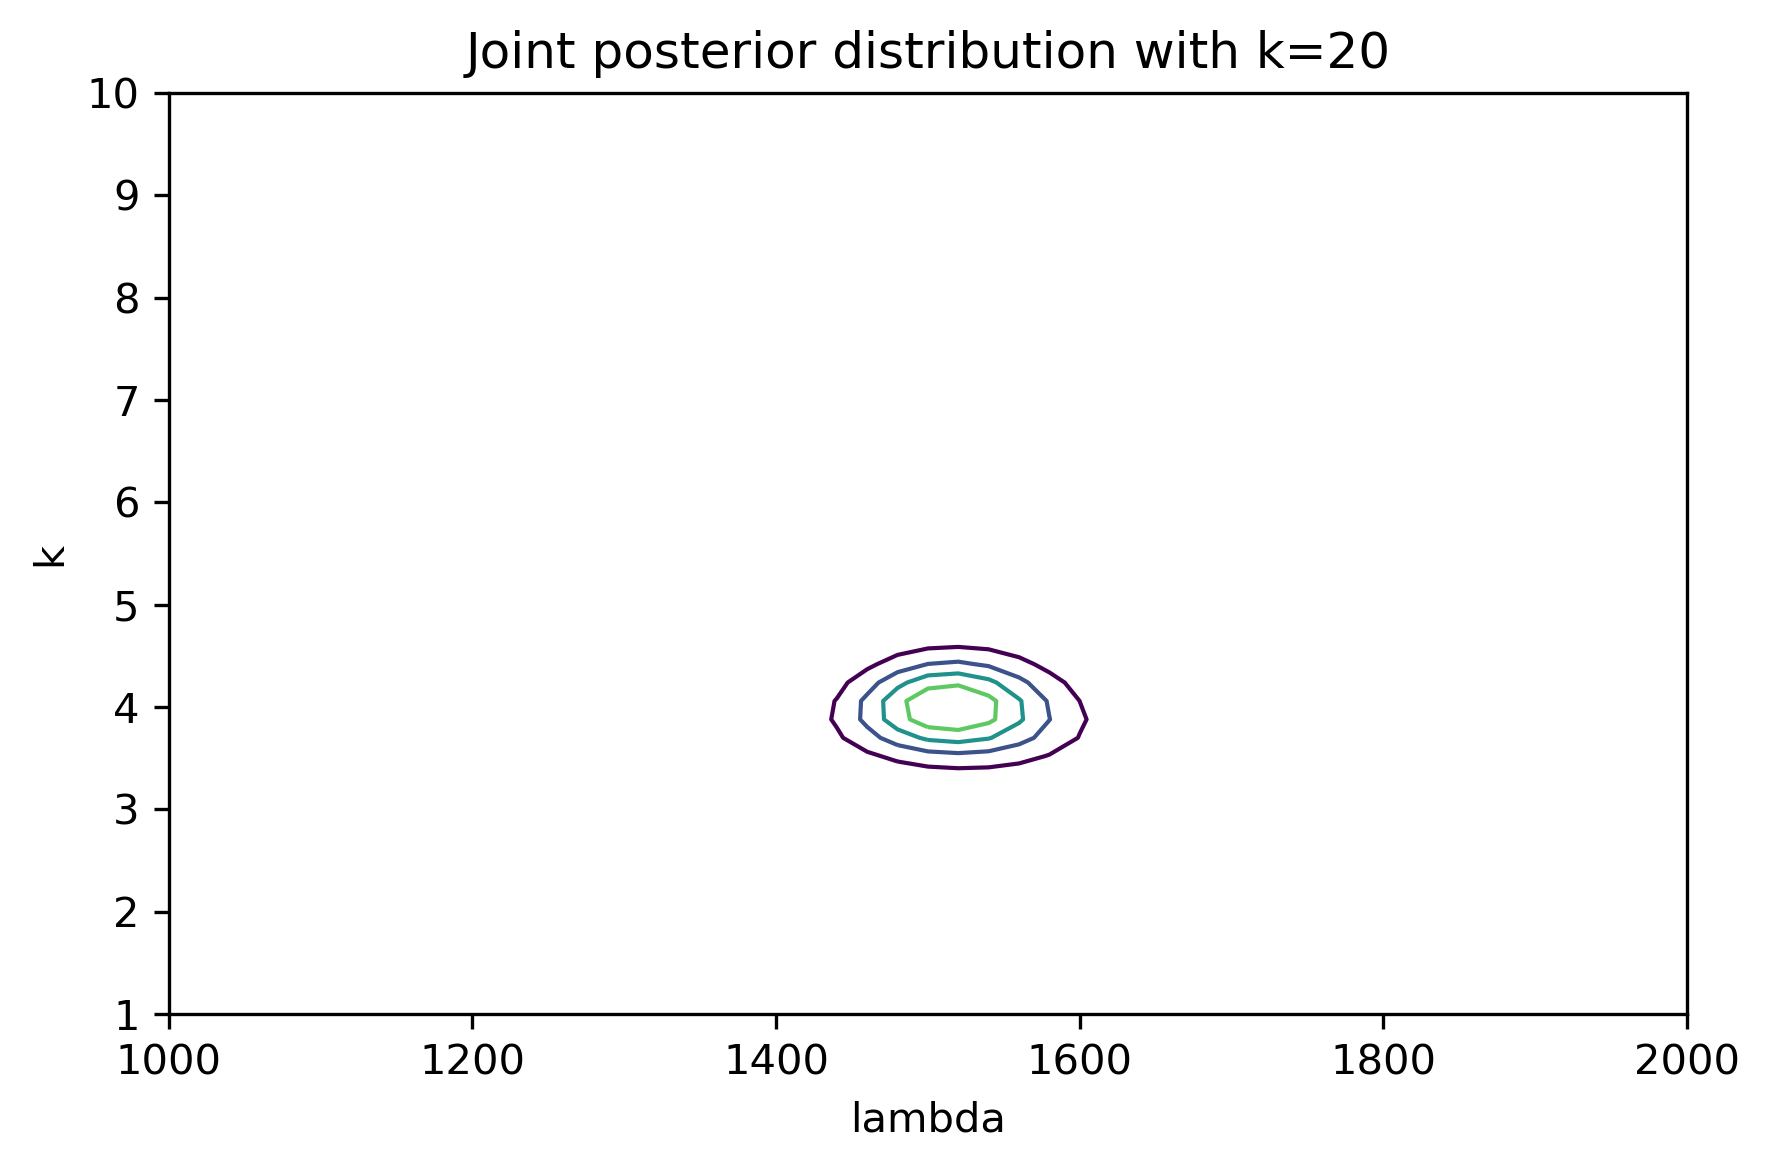

In [74]:
# Solution

posterior_bulb3 = posterior_bulb * likelihood
normalize(posterior_bulb3)
plot_contour(posterior_bulb3)
decorate(title='Joint posterior distribution with k=20')

In [75]:
# Solution

# Since there were more dead bulbs than expected,
# the posterior mean is a bit less after the update.

joint_weibull_mean(posterior_bulb3)

1378.3949572816412

**Exercise:** In this exercise, we'll use one month of data to estimate the parameters of a distribution that describes daily rainfall in Seattle.
Then we'll compute the posterior predictive distribution for daily rainfall and use it to estimate the probability of a rare event, like more than 1.5 inches of rain in a day.

According to hydrologists, the distribution of total daily rainfall (for days with rain) is well modeled by a two-parameter
gamma distribution.

When we worked with the one-parameter gamma distribution in <<_TheGammaDistribution>>, we used the Greek letter $\alpha$ for the parameter.

For the two-parameter gamma distribution, we will use $k$ for the "shape parameter", which determines the shape of the distribution, and the Greek letter $\theta$ or `theta` for the "scale parameter". 

The following function takes these parameters and returns a `gamma` object from SciPy.

In [76]:
import scipy.stats

def gamma_dist(k, theta):
    """Makes a gamma object.
    
    k: shape parameter
    theta: scale parameter
    
    returns: gamma object
    """
    return scipy.stats.gamma(k, scale=theta)

Now we need some data.
The following cell downloads data I collected from the National Oceanic and Atmospheric Administration ([NOAA](http://www.ncdc.noaa.gov/cdo-web/search)) for Seattle, Washington in May 2020.

In [77]:
# Load the data file

datafile = '2203951.csv'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2203951.csv

Now we can load it into a `DataFrame`:

In [78]:
weather = pd.read_csv('2203951.csv')
weather.head()

,STATION,NAME,DATE,AWND,PRCP,TMAX,TMIN,WT01,WT03,WT08
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-01,4.47,0.00,66,43,NaN,NaN,NaN
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-02,9.40,0.24,58,47,1.0,NaN,NaN
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-03,11.63,0.06,57,44,1.0,NaN,NaN
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-04,4.47,0.00,65,39,NaN,NaN,NaN
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2020-05-05,7.83,0.00,71,49,NaN,NaN,NaN


I'll make a Boolean Series to indicate which days it rained.

In [79]:
rained = weather['PRCP'] > 0
rained.sum()

14

And select the total rainfall on the days it rained.

In [80]:
prcp = weather.loc[rained, 'PRCP']
prcp.describe()

count    14.000000
mean      0.222857
std       0.301060
min       0.010000
25%       0.052500
50%       0.110000
75%       0.225000
max       1.140000
Name: PRCP, dtype: float64

Here's what the CDF of the data looks like.

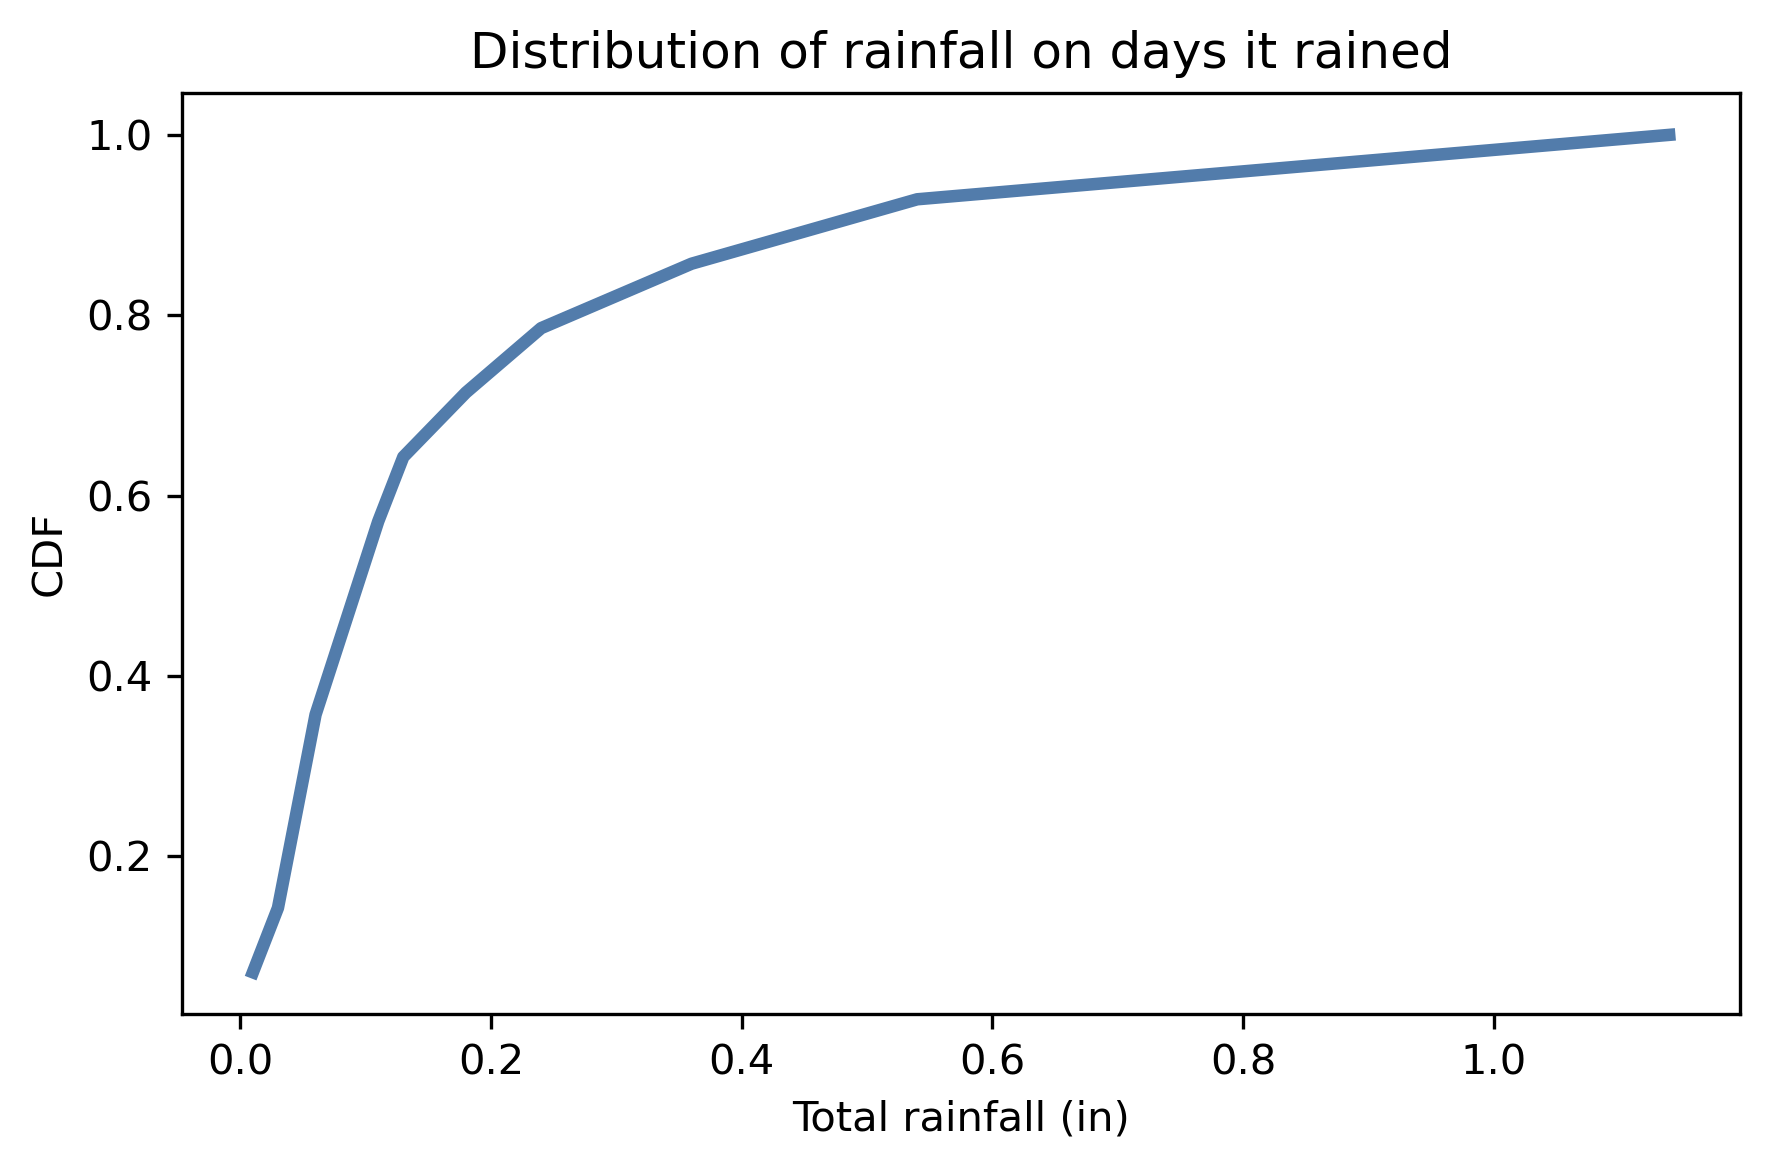

In [81]:
cdf_data = Cdf.from_seq(prcp)
cdf_data.plot()
decorate(xlabel='Total rainfall (in)',
         ylabel='CDF',
         title='Distribution of rainfall on days it rained')

The maximum is 1.14 inches of rain is one day.
To estimate the probability of more than 1.5 inches, we need to extrapolate from the data we have, so our estimate will depend on whether the gamma distribution is really a good model.

I suggest you proceed in the following steps:

1. Construct a prior distribution for the parameters of the gamma distribution.  Note that $k$ and $\theta$ must be greater than 0.

2. Use the observed rainfalls to update the distribution of parameters.

3. Compute the posterior predictive distribution of rainfall, and use it to estimate the probability of getting more than 1.5 inches of rain in one day.

In [82]:
# Solution

# I'll use the MLE parameters of the gamma distribution
# to help me choose priors

k_est, _, theta_est = scipy.stats.gamma.fit(prcp, floc=0)
k_est, theta_est

(0.8898876017525283, 0.25043291132301665)

In [83]:
# Solution

# I'll use uniform priors for the parameters.
# I chose the upper bounds by trial and error.

ks = np.linspace(0.01, 2, num=51)
prior_k = make_uniform(ks, name='k')

In [84]:
# Solution

thetas = np.linspace(0.01, 1.5, num=51)
prior_theta = make_uniform(thetas, name='theta')

In [85]:
# Solution

# Here's the joint prior

prior = make_joint(prior_k, prior_theta)

In [86]:
# Solution

# I'll use a grid to compute the densities

k_mesh, theta_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, prcp)

In [87]:
# Solution

# Here's the 3-D array of densities

densities = gamma_dist(k_mesh, theta_mesh).pdf(data_mesh) 
densities.shape

(51, 51, 14)

In [88]:
# Solution

# Which we reduce by multiplying along axis 2

likelihood = densities.prod(axis=2)
likelihood.sum()

150287.91980136462

In [89]:
# Solution

# Now we can do the update in the usual way

posterior = prior * likelihood
normalize(posterior)

57.780822684107896

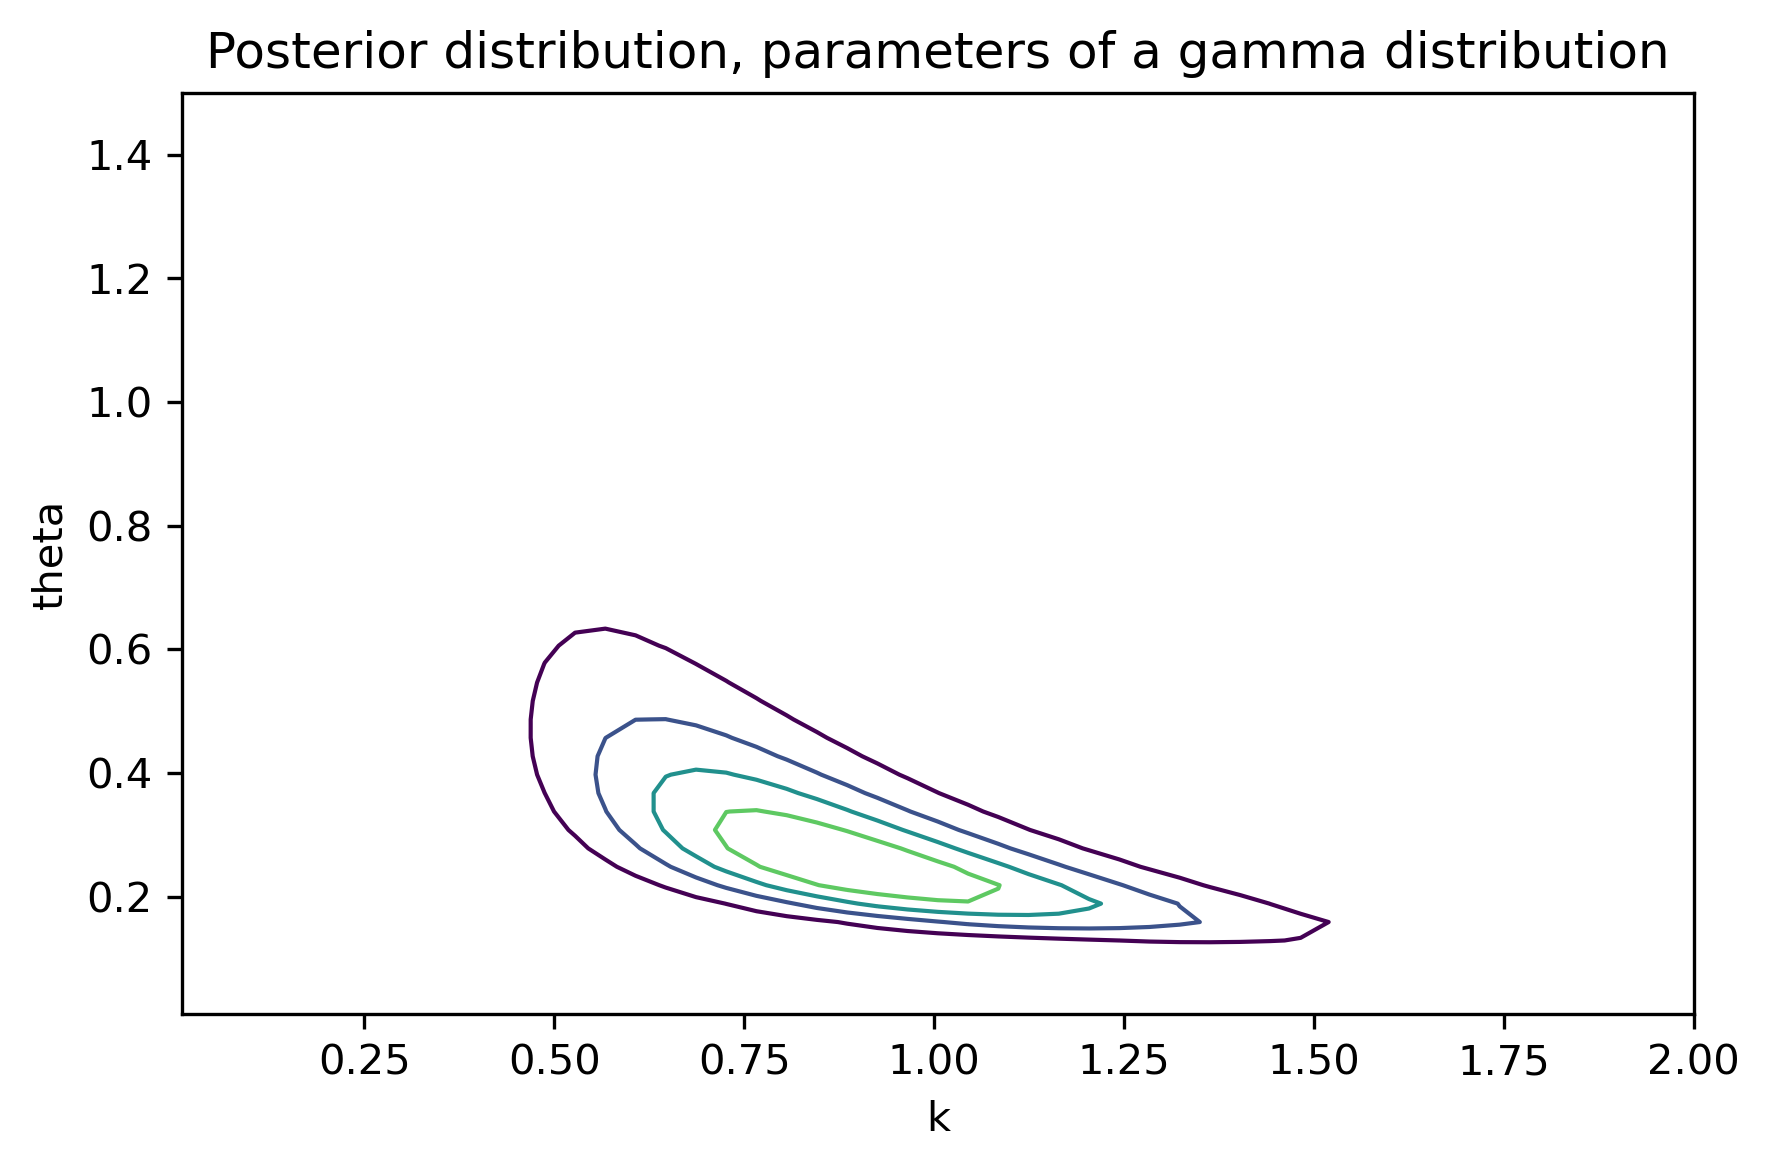

In [90]:
# Solution

# And here's what the posterior looks like

plot_contour(posterior)

decorate(title='Posterior distribution, parameters of a gamma distribution')

In [91]:
# Solution

# I'll check the marginal distributions to make sure the
# range of the priors is wide enough

from utils import marginal

posterior_k = marginal(posterior, 0)
posterior_theta = marginal(posterior, 1)

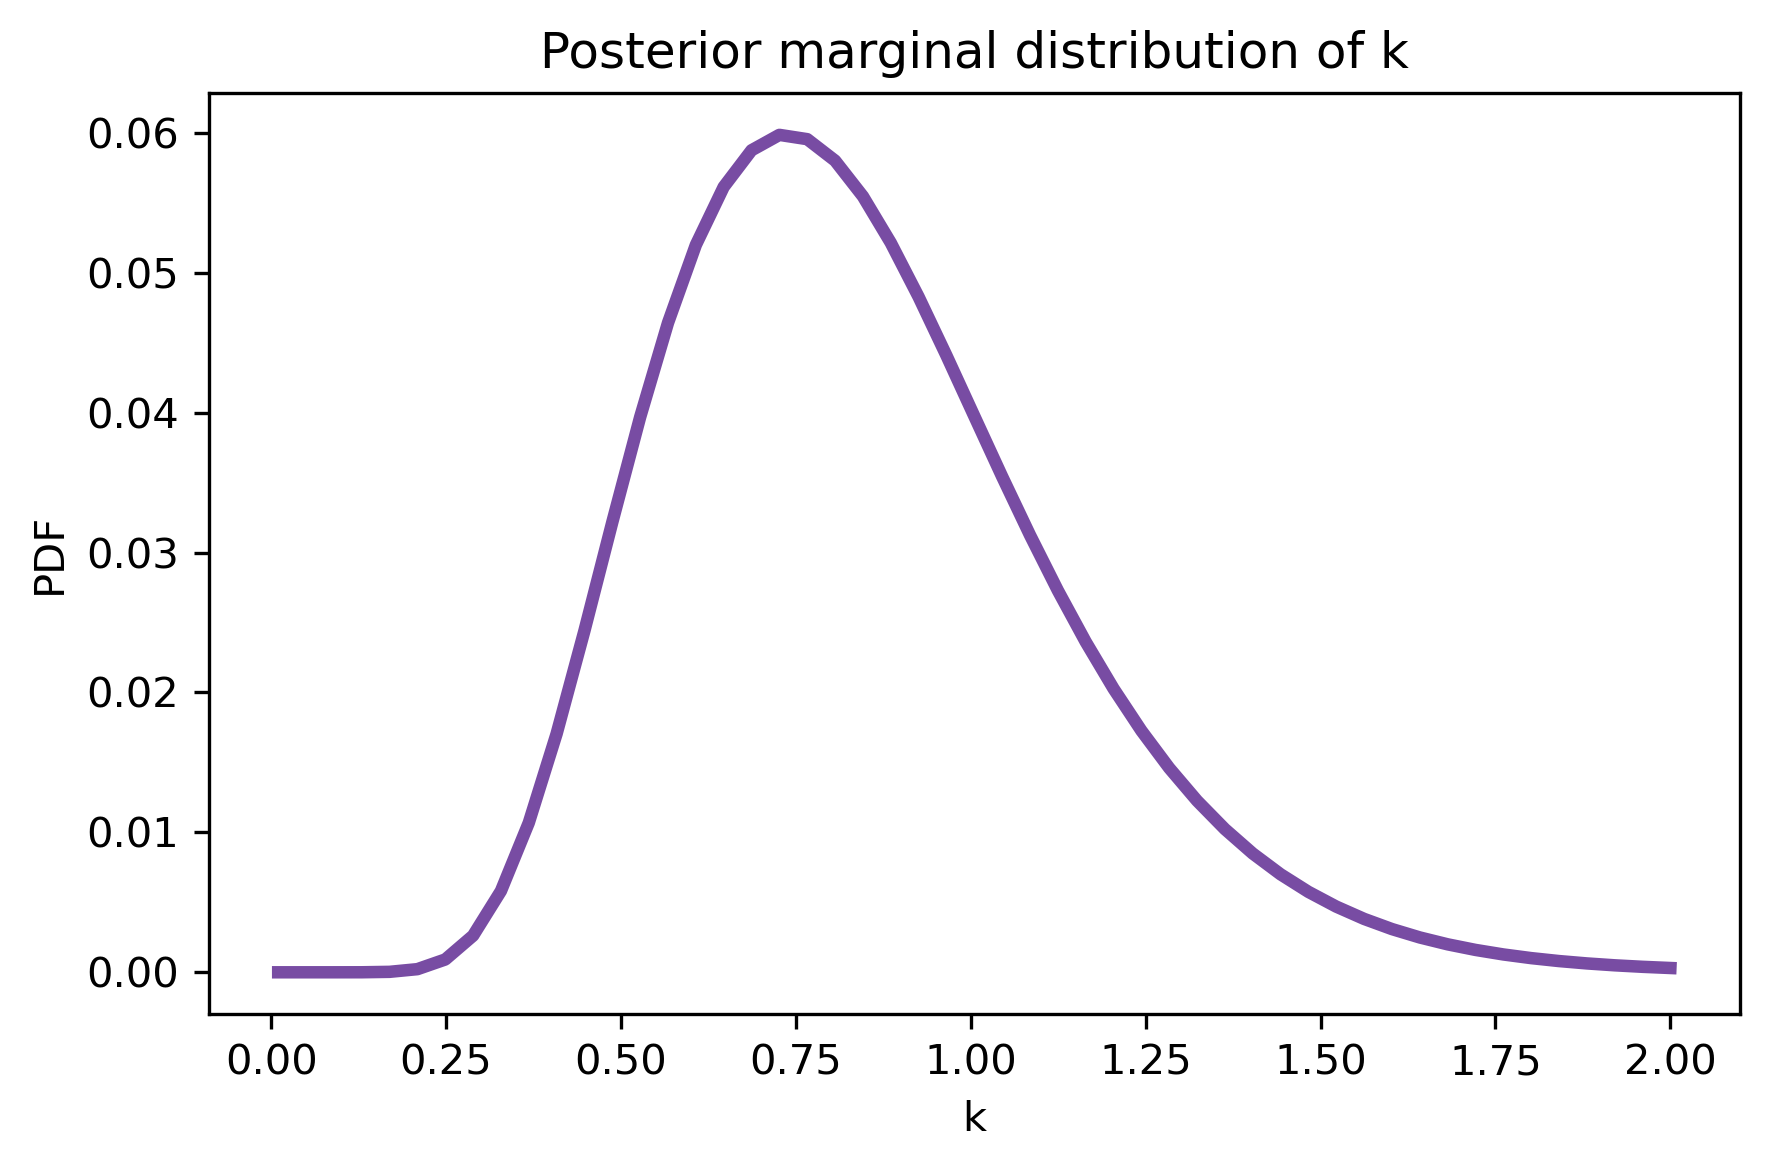

In [92]:
# Solution

# The marginal distribution for k is close to 0 at both ends

posterior_k.plot(color='C4')
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

In [93]:
# Solution

posterior_k.mean(), posterior_k.credible_interval(0.9)

(0.8437218523899558, array([0.4478, 1.3632]))

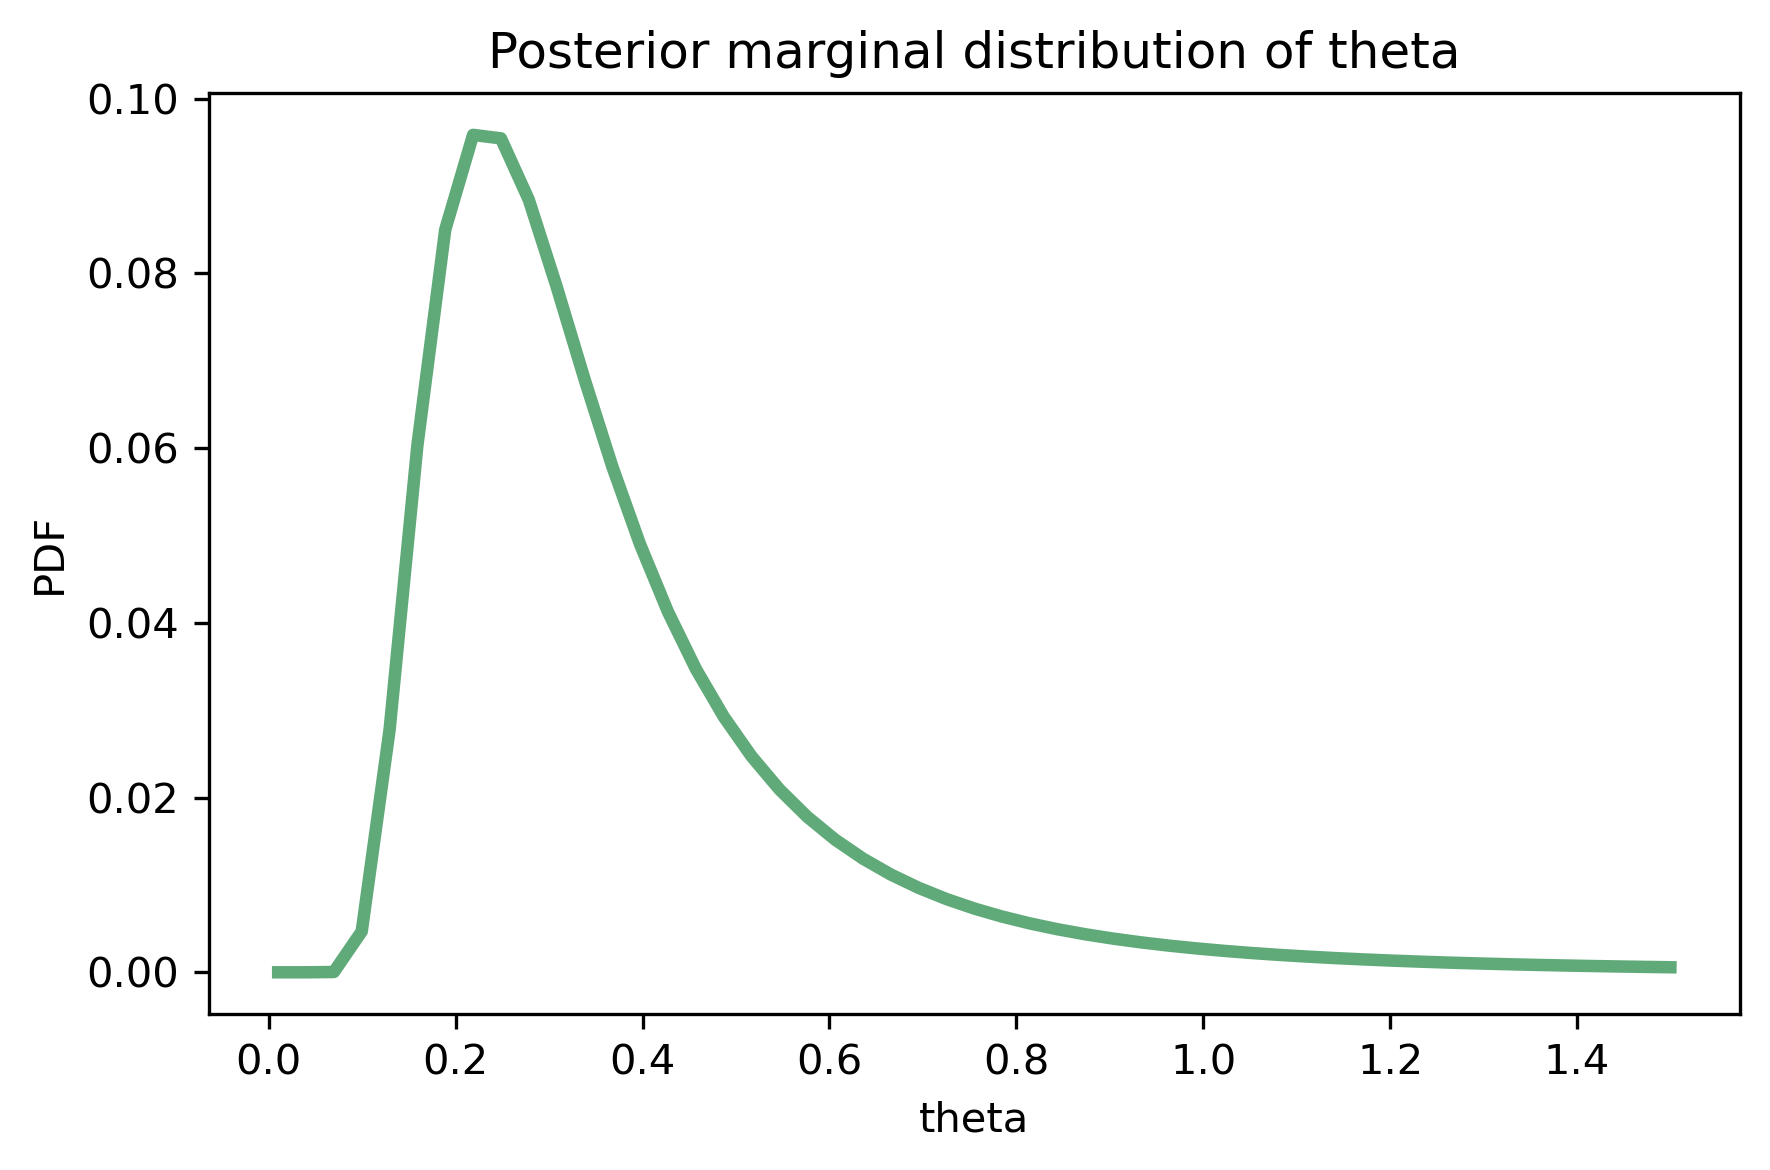

In [94]:
# Solution

# Same with the marginal distribution of theta

posterior_theta.plot(color='C2')
decorate(xlabel='theta',
         ylabel='PDF', 
         title='Posterior marginal distribution of theta')

In [95]:
# Solution

posterior_theta.mean(), posterior_theta.credible_interval(0.9)

(0.367761307460383, array([0.159 , 0.7848]))

In [96]:
# Solution

# To compute the posterior predictive distribution,
# I'll stack the joint posterior to make a Series
# with a MultiIndex

posterior_series = posterior.stack()
posterior_series.head()

theta  k     
0.01   0.0100    4.306265e-156
       0.0498    1.304069e-145
       0.0896    2.463890e-141
       0.1294    2.077828e-138
       0.1692    4.227218e-136
dtype: float64

In [97]:
# Solution

# I'll extend the predictive distribution up to 2 inches

low, high = 0.01, 2

In [98]:
# Solution

# Now we can iterate through `posterior_series`
# and make a sequence of predictive Pmfs, one
# for each possible pair of parameters

from utils import pmf_from_dist

qs = np.linspace(low, high, num=101)
pmf_seq = []
for (theta, k) in posterior_series.index:
    dist = gamma_dist(k, theta)
    pmf = pmf_from_dist(dist, qs)
    pmf_seq.append(pmf)

In [99]:
# Solution

# And we can use `make_mixture` to make the posterior predictive
# distribution

post_pred = make_mixture(posterior_series, pmf_seq)

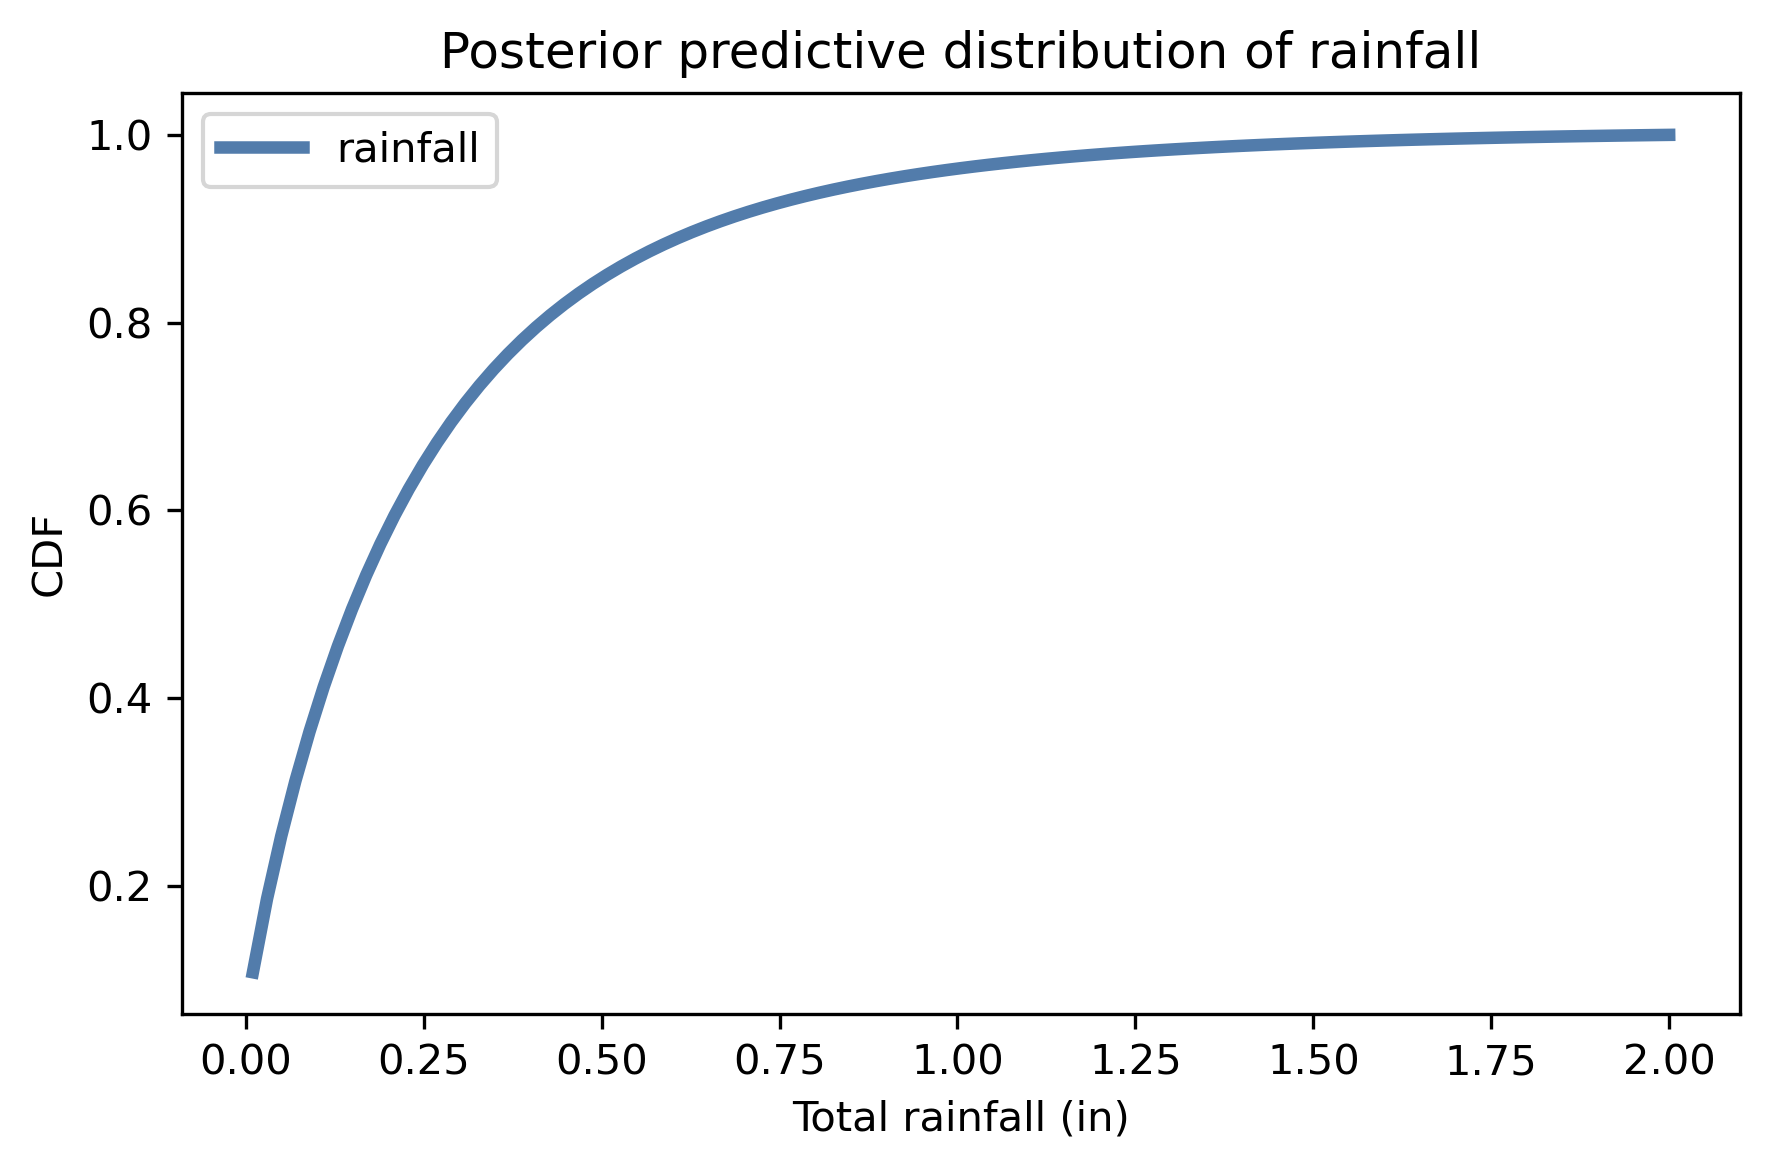

In [100]:
# Solution

# Here's what it looks like.

post_pred.make_cdf().plot(label='rainfall')
decorate(xlabel='Total rainfall (in)',
         ylabel='CDF',
         title='Posterior predictive distribution of rainfall')

In [101]:
# Solution 

# The probability of more than 1.5 inches of rain is small

cdf = post_pred.make_cdf()
p_gt = 1 - cdf(1.5)
p_gt

0.00900003598887611

In [102]:
# Solution 

# So it's easier to interpret as the number of rainy
# days between events, on average

1 / p_gt

111.11066680577532